# Sentence Modeling Via Author-Topic & GSDMM

In [5]:
# Get Resources
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import AuthorTopicModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# For gsdmm model
import pickle
import pandas as pd
import numpy as np
from gsdmm import MovieGroupProcess

## Stopwords

In [8]:
# Get 19th century stopwords
stop_words = pd.read_csv("jockers.csv")
stop_words = stop_words['word'].values.astype(str).tolist()
len(stop_words)

5631

During author-topic modeling, the proper name carrother appeared frequently. It will be added to the stop_word list, which contains other proper names. 

In [9]:
#Add this term to stop_words list.
stop_words.append("carrothers")
len(stop_words)

5632

## Get Data

In [10]:
# Sentence Data
df = pd.read_csv("20210119_AM_Data4TopicModel.csv") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37608 entries, 0 to 37607
Data columns (total 62 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               37608 non-null  int64  
 1   docsequence              37608 non-null  int64  
 2   docid                    37608 non-null  object 
 3   docyear                  37414 non-null  float64
 4   doctype                  37608 non-null  object 
 5   allsubject               37608 non-null  object 
 6   broadsubj                37608 non-null  object 
 7   personalevent            6384 non-null   object 
 8   wwritten                 37608 non-null  object 
 9   docauthorid              37608 non-null  object 
 10  docauthorname            37608 non-null  object 
 11  language                 37608 non-null  object 
 12  editor                   25798 non-null  object 
 13  briefname                37608 non-null  object 
 14  nationality           

In [11]:
# Confirm that Unnamed column can serve as sentenceID
df['Unnamed: 0'].describe()

count    37608.000000
mean     18804.500000
std      10856.638798
min          1.000000
25%       9402.750000
50%      18804.500000
75%      28206.250000
max      37608.000000
Name: Unnamed: 0, dtype: float64

In [12]:
# Change column name to "SentenceID"
df = df.rename(columns={'Unnamed: 0':'sentenceID'})
list(df)

['sentenceID',
 'docsequence',
 'docid',
 'docyear',
 'doctype',
 'allsubject',
 'broadsubj',
 'personalevent',
 'wwritten',
 'docauthorid',
 'docauthorname',
 'language',
 'editor',
 'briefname',
 'nationality',
 'birthyear',
 'deathyear',
 'birthplace',
 'deathplace',
 'ageatdeath',
 'nativeoccupation',
 'yearimmigration',
 'stayednorthamerica.x',
 'agewriting',
 'marriagestatus',
 'maternalstatus',
 'authorgeneration',
 'authorgender',
 'culturalheritage',
 'religion',
 'northamericanoccupation',
 'religionNew',
 'nationalOrigin',
 'culture',
 'sinceMigration',
 'authorLocation',
 'A',
 'Agricultural',
 'I',
 'Industrial',
 'CCP',
 'Commercial',
 'Professional',
 'Domestic',
 'Social',
 'Government',
 'Other',
 'docmonth',
 'docday',
 'docMonth',
 'docDay',
 'docdate',
 'docDate',
 'letterOrphan',
 'letterLast',
 'Sentence',
 'Sequence',
 'Sentiment',
 'Sentences',
 'Position',
 'Last',
 'SentimentLTR']

In [13]:
# Verify number of sentences
df['Sentence'].count()

37608

## Process text

In [14]:
# Convert values in sentencecs to list of strings (objects)
data = df.Sentence.values.tolist()
data[:5]

[' baltimore 20 september 1836 dear heinrich: friday evening, 16 september, anchor was dropped and we had safely arrived in the harbor!',
 'it was a long and arduous voyage!',
 'however we were and are all well and thank the father in heaven that he has protected us so far!',
 'i had written down the events of the voyage for you, but to my great annoyance i am now missing the whole notebook; perhaps i will find it later.',
 'as you know, we set sail on 12 july.']

In [15]:
# Define function to convert texts into a list of lowercase tokens

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), 
                                             deacc=True))   # removes accents

data_words = list(sent_to_words(data))

print(data_words[:5])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'was', 'dropped', 'and', 'we', 'had', 'safely', 'arrived', 'in', 'the', 'harbor'], ['it', 'was', 'long', 'and', 'arduous', 'voyage'], ['however', 'we', 'were', 'and', 'are', 'all', 'well', 'and', 'thank', 'the', 'father', 'in', 'heaven', 'that', 'he', 'has', 'protected', 'us', 'so', 'far'], ['had', 'written', 'down', 'the', 'events', 'of', 'the', 'voyage', 'for', 'you', 'but', 'to', 'my', 'great', 'annoyance', 'am', 'now', 'missing', 'the', 'whole', 'notebook', 'perhaps', 'will', 'find', 'it', 'later'], ['as', 'you', 'know', 'we', 'set', 'sail', 'on', 'july']]


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [19]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [20]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) # Per Jockers & Mimno (2013)

In [21]:
print(data_words_nostops[:10])

[['baltimore', 'dear', 'heinrich', 'friday', 'evening', 'anchor', 'dropped', 'safely', 'arrived', 'harbor'], ['arduous', 'voyage'], ['thank', 'father', 'heaven', 'protected'], ['written', 'events', 'voyage', 'annoyance', 'missing', 'notebook', 'find'], ['set', 'sail', 'july'], ['afternoon', 'pilot', 'began', 'hold', 'head', 'overboard', 'bernhard', 'schwarze', 'children'], ['morning', 'felt', 'remained', 'bed', 'days', 'time', 'vomit', 'times', 'pretty', 'passengers'], ['spared'], ['wind', 'adverse', 'evening', 'remained', 'weeks', 'pass', 'english', 'channel', 'cope', 'heavy', 'weather', 'north', 'sea'], ['open', 'sea', 'things', 'fine', 'sailed', 'southward', 'experienced', 'calm', 'heat']]


In [22]:
print(data_words_bigrams[:10])

[['baltimore', 'dear', 'heinrich', 'friday', 'evening', 'anchor', 'dropped', 'safely', 'arrived', 'harbor'], ['arduous', 'voyage'], ['thank', 'father', 'heaven', 'protected'], ['written', 'events', 'voyage', 'annoyance', 'missing', 'notebook', 'find'], ['set', 'sail', 'july'], ['afternoon', 'pilot', 'began', 'hold', 'head', 'overboard', 'bernhard', 'schwarze', 'children'], ['morning', 'felt', 'remained', 'bed', 'days', 'time', 'vomit', 'times', 'pretty', 'passengers'], ['spared'], ['wind', 'adverse', 'evening', 'remained', 'weeks', 'pass', 'english', 'channel', 'cope', 'heavy', 'weather', 'north', 'sea'], ['open', 'sea', 'things', 'fine', 'sailed', 'southward', 'experienced', 'calm', 'heat']]


In [23]:
print(data_lemmatized[:3])

[['evening', 'anchor', 'harbor'], ['voyage'], []]


In [59]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [61]:
# View
corpus[:3]

[[(0, 1), (1, 1), (2, 1)], [(3, 1)], []]

In [62]:
id2word[7]

'notebook'

In [63]:
id2word.id2token

{0: 'anchor',
 1: 'evening',
 2: 'harbor',
 3: 'voyage',
 4: 'annoyance',
 5: 'event',
 6: 'find',
 7: 'notebook',
 8: 'sail',
 9: 'afternoon',
 10: 'child',
 11: 'head',
 12: 'pilot',
 13: 'bed',
 14: 'day',
 15: 'morning',
 16: 'passenger',
 17: 'time',
 18: 'vomit',
 19: 'channel',
 20: 'north',
 21: 'sea',
 22: 'weather',
 23: 'week',
 24: 'heat',
 25: 'thing',
 26: 'land',
 27: 'longing',
 28: 'reach',
 29: 'food',
 30: 'ham',
 31: 'water',
 32: 'wine',
 33: 'lot',
 34: 'deck',
 35: 'shade',
 36: 'attendance',
 37: 'chaplain',
 38: 'name',
 39: 'godparent',
 40: 'meal',
 41: 'noon',
 42: 'schniederjan',
 43: 'fish',
 44: 'beef',
 45: 'dolphin',
 46: 'steak',
 47: 'trip',
 48: 'cape',
 49: 'ship',
 50: 'bay',
 51: 'lie',
 52: 'fruit',
 53: 'note',
 54: 'soil',
 55: 'night',
 56: 'church',
 57: 'heart',
 58: 'minute',
 59: 'hour',
 60: 'steerage',
 61: 'assistant',
 62: 'bench',
 63: 'people',
 64: 'quarantine',
 65: 'collect',
 66: 'thought',
 67: 'brother',
 68: 'deal',
 69: 'trou

In [64]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[('anchor', 1), ('evening', 1), ('harbor', 1)], [('voyage', 1)], []]

## Author Topic Model

Source: https://nbviewer.jupyter.org/github/rare-technologies/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb

In [65]:
# Create author2doc dictionary
author2doc = df.groupby(['docauthorid'])['sentenceID'].apply(list).to_dict()

In [66]:
# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)
_ = dictionary[0]  # This sort of "initializes" dictionary.id2token.

In [67]:
# Create Corpus
docs = data_lemmatized

In [68]:
# Make bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [69]:
# Verify data
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of authors: 218
Number of unique tokens: 7791
Number of documents: 37608


In [70]:
# Create doc2author from author2doc
doc2author = gensim.models.atmodel.construct_doc2author(corpus, author2doc)

In [71]:
# Regenerate author2doc from doc2author
# Model was throwing errors otherwise
author2doc = gensim.models.atmodel.construct_author2doc(doc2author)

In [72]:
# Quick run of author-topic model using optimal number of topics from LDA Mallet model.
%time model = AuthorTopicModel(corpus=corpus, num_topics=24, id2word=dictionary.id2token, \
                author2doc=author2doc, chunksize=2000, passes=5, eval_every=0, \
                iterations=1, random_state=1)

CPU times: user 1min 20s, sys: 3.08 s, total: 1min 23s
Wall time: 1min 29s


In [73]:
# View topics and coherence scores.
model.top_topics(texts = docs, dictionary = dictionary, coherence='c_v')

[([(0.01566376335751764, 'settler'),
   (0.014368637461534375, 'irishman'),
   (0.011238562456673193, 'criminal'),
   (0.010585999882860693, 'machinist'),
   (0.00967407435838017, 'anchor'),
   (0.00941988784084416, 'tobacco'),
   (0.00873408085421676, 'cotton'),
   (0.008501054594176128, 'oil'),
   (0.008389228415666064, 'art'),
   (0.007766547766219598, 'pump'),
   (0.0067710520465316905, 'strife'),
   (0.006694335657539308, 'tide'),
   (0.006602602330470899, 'breeze'),
   (0.006289372781487199, 'sucker'),
   (0.006058230958804838, 'buffalo'),
   (0.005795489299806609, 'oxen'),
   (0.005507489942375747, 'atom'),
   (0.005247936030711377, 'box'),
   (0.0049261342434433406, 'pavilion'),
   (0.004757293010167287, 'brushwood')],
  0.7150267726771643),
 ([(0.024678207618681947, 'seafarer'),
   (0.017384099600407512, 'ruble'),
   (0.0123917710745945, 'myth'),
   (0.012391771053018365, 'crow'),
   (0.01239177104464696, 'tension'),
   (0.012391771027269015, 'sanctuary'),
   (0.01239177096936

In [74]:
# Rejig the function from above to generate coherence scores for author-topic models with a range of topic counts
def compute_coherence_valuesAT(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of author-topic topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_valuesAT = []
    model_listAT = []
    for num_topics in range(start, limit, step):
        modelAT = AuthorTopicModel(corpus=corpus, num_topics=num_topics, id2word=dictionary.id2token, \
                author2doc=author2doc, chunksize=2000, passes=1, eval_every=0, \
                iterations=1, random_state=1)
        model_listAT.append(modelAT)
        coherencemodelAT = CoherenceModel(model=modelAT, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_valuesAT.append(coherencemodelAT.get_coherence())

    return model_listAT, coherence_valuesAT

In [75]:
# Run models and coherence call.
model_listAT, coherence_valuesAT = compute_coherence_valuesAT(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=docs, 
                                                        start=3, 
                                                        limit=27, 
                                                        step=1)

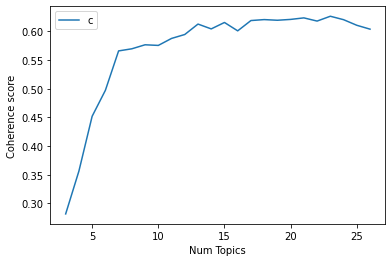

In [76]:
# Show graph
limit=27; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_valuesAT)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values Author-Topic Model"), loc='best')
plt.show()

In [77]:
len(model_listAT)

24

In [78]:
# Print the coherence scores for author topics models
for m, cv in zip(x, coherence_valuesAT):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.2817
Num Topics = 4  has Coherence Value of 0.3563
Num Topics = 5  has Coherence Value of 0.4519
Num Topics = 6  has Coherence Value of 0.4971
Num Topics = 7  has Coherence Value of 0.5659
Num Topics = 8  has Coherence Value of 0.5696
Num Topics = 9  has Coherence Value of 0.5766
Num Topics = 10  has Coherence Value of 0.5755
Num Topics = 11  has Coherence Value of 0.5877
Num Topics = 12  has Coherence Value of 0.5945
Num Topics = 13  has Coherence Value of 0.6127
Num Topics = 14  has Coherence Value of 0.6043
Num Topics = 15  has Coherence Value of 0.6155
Num Topics = 16  has Coherence Value of 0.6009
Num Topics = 17  has Coherence Value of 0.6189
Num Topics = 18  has Coherence Value of 0.6205
Num Topics = 19  has Coherence Value of 0.6194
Num Topics = 20  has Coherence Value of 0.6209
Num Topics = 21  has Coherence Value of 0.6235
Num Topics = 22  has Coherence Value of 0.618
Num Topics = 23  has Coherence Value of 0.6264
Num Topics = 24  has 

In [79]:
# Coherence values
coherence_valuesAT[20]

0.6263858703492138

In [80]:
# Topics for 7-topic author-topic model
ATModel_23 = model_listAT[20]
ATmodel_topics_23 = ATModel_23.show_topics(formatted=False)
pprint(ATModel_23.print_topics(num_words=10))

[(18,
  '0.020*"pavilion" + 0.015*"polling" + 0.014*"ballot" + 0.011*"functionary" + '
  '0.011*"theoretician" + 0.008*"stout" + 0.006*"excess" + 0.006*"ban" + '
  '0.006*"pea" + 0.006*"prohibition"'),
 (20,
  '0.016*"ruble" + 0.011*"fore" + 0.011*"coward" + 0.010*"cringe" + '
  '0.008*"policy" + 0.008*"pier" + 0.007*"bark" + 0.006*"sister" + '
  '0.006*"apprenticeship" + 0.005*"marl"'),
 (14,
  '0.008*"anarchist" + 0.007*"gluttony" + 0.007*"intoxication" + '
  '0.006*"franchise" + 0.006*"applause" + 0.005*"socialist" + 0.005*"anarchy" '
  '+ 0.005*"socialism" + 0.005*"workday" + 0.004*"striker"'),
 (3,
  '0.007*"township" + 0.004*"chopping" + 0.003*"nowise" + 0.002*"harrow" + '
  '0.002*"applause" + 0.002*"allude" + 0.002*"conservative" + 0.002*"emigrant" '
  '+ 0.002*"carpentry" + 0.002*"operative"'),
 (21,
  '0.015*"goose" + 0.005*"settler" + 0.004*"hauling" + 0.003*"donkey" + '
  '0.003*"idol" + 0.003*"starving" + 0.003*"stint" + 0.003*"lace" + '
  '0.002*"gin" + 0.002*"replacement

In [69]:
# Save model.
ATModel_23.save('ATModel_23')

In [317]:
gamma, _ = ATModel_22.inference(corpus, author2doc, doc2author, 0)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ATModel_24, corpus, id2word)
vis

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: inference() missing 3 required positional arguments: 'author2doc', 'doc2author', and 'rhot'

In [231]:
topic_labels = ['0 - Pastry Insurrection', '1 - Time', '2 - Communication', '3 - Spit Sucker', '4 - Conservative Bum', '5 - Travel', '6 - Anarchist Postmark', '7 - Farming', '8 - Frontier', '9 - Community']

for topic in model.show_topics(num_topics=10):
    print('Label: ' + topic_labels[topic[0]])
    words = ''
    for word, prob in model.show_topic(topic[0]):
        words += word + ' '
    print('Words: ' + words)
    print()

Label: 0 - Pastry Insurrection
Words: take time work give come day place people sister year 

Label: 1 - Time
Words: letter write little dear time send day child hear live 

Label: 2 - Communication
Words: norwegian carrother vestland scandinavian conservative anarchist cosin postmark bum applause 

Label: 3 - Spit Sucker
Words: country land year dollar acre farm place work ship day 

Label: 4 - Conservative Bum
Words: see water reach day foot look cover call pass large 



In [208]:
model['per0000238']

[(1, 0.41521130355973146),
 (2, 0.20747345445700952),
 (5, 0.07266144331005227),
 (7, 0.21725274933366595),
 (8, 0.015659860257582044),
 (9, 0.07045289943332343)]

# GSDMM

Code adapted from Amrouche (2019).

In [90]:
# Useful libs
import pickle
import pandas as pd
import numpy as np
import gsdmm

In [92]:
from gsdmm import MovieGroupProcess

In [39]:
mgp = MovieGroupProcess(K=27, alpha=0.1, beta=0.1, n_iters=30)

In [83]:
docs = data_lemmatized

In [84]:
vocab = set(x for doc in docs for x in doc)

In [156]:
docs[:10]

[['evening', 'anchor', 'harbor'],
 ['voyage'],
 [],
 ['event', 'annoyance', 'notebook', 'find'],
 ['sail'],
 ['afternoon', 'pilot', 'head', 'child'],
 ['morning', 'bed', 'day', 'time', 'vomit', 'time', 'passenger'],
 [],
 ['evening', 'week', 'channel', 'weather', 'north', 'sea'],
 ['sea', 'thing', 'heat']]

In [149]:
docs.count([])

5688

In [154]:
emptyIndices = [i for i in range(len(docs)) if docs[i] == []] 

In [157]:
len(emptyIndices)

5688

This is too many empty values. Add verbs back into dataset. 

In [178]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB']) # Per Jockers & Mimno (2013) & Moreton (2016)

In [179]:
docs = data_lemmatized

In [180]:
docs.count([])

2366

This is still too many empty docs -- how about if we allow personal pronouns back in, per Moreton (2016)

In [17]:
perPronouns = ["i", "you", "we", "she", "he", "they", "it"]  

In [19]:
stopwordsNew = [ele for ele in stop_words if ele not in perPronouns]

In [20]:
len(stopwordsNew)

5625

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwordsNew] for doc in texts]

In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [26]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'VERB', 'PRP']) # Per Jockers & Mimno (2013) & Moreton (2016)

In [27]:
docs = data_lemmatized

In [29]:
docs.count([])

2208

In [32]:
emptyIndices = [i for i in range(len(docs)) if docs[i] == []] 

In [35]:
docs = [x for x in docs if x != []]
len(docs)

35400

In [36]:
vocab = set(x for doc in docs for x in doc)

In [37]:
n_terms = len(vocab)

In [40]:
y = mgp.fit(docs, n_terms)

In stage 0: transferred 32630 clusters with 27 clusters populated
In stage 1: transferred 26728 clusters with 27 clusters populated
In stage 2: transferred 23019 clusters with 27 clusters populated
In stage 3: transferred 20375 clusters with 27 clusters populated
In stage 4: transferred 18966 clusters with 27 clusters populated
In stage 5: transferred 17801 clusters with 27 clusters populated
In stage 6: transferred 16986 clusters with 27 clusters populated
In stage 7: transferred 16312 clusters with 27 clusters populated
In stage 8: transferred 15720 clusters with 27 clusters populated
In stage 9: transferred 15334 clusters with 27 clusters populated
In stage 10: transferred 15098 clusters with 27 clusters populated
In stage 11: transferred 14884 clusters with 26 clusters populated
In stage 12: transferred 14807 clusters with 25 clusters populated
In stage 13: transferred 14611 clusters with 24 clusters populated
In stage 14: transferred 14367 clusters with 23 clusters populated
In st

In [41]:
with open('dumps/trained_models/v1.model', 'wb') as f:
    pickle.dump(mgp, f)
    f.close()

In [44]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)


Number of documents per topic : [1094    0 2689  102    2    0  494 6002    0  558    0    0  162 3649
    1  245    0 2983 4020 1290    0 2479  317 1449 5839  621 1404]


In [45]:
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):',
top_index)

Most important clusters (by number of docs inside): [ 7 24 18 13 17  2 21 23 26 19]


In [46]:
mgp.cluster_word_distribution

[{'lot': 4,
  'thing': 20,
  'heart': 66,
  'look': 34,
  'time': 38,
  'sister': 7,
  'come': 13,
  'speak': 14,
  'year': 23,
  'person': 16,
  'make': 5,
  'spot': 6,
  'show': 11,
  'care': 19,
  'day': 29,
  'evening': 2,
  'want': 19,
  'do': 10,
  'letter': 9,
  'find': 19,
  'forget': 18,
  'age': 5,
  'take': 36,
  'die': 20,
  'bring': 18,
  'write': 9,
  'girl': 6,
  'call': 15,
  'child': 51,
  'sleep': 13,
  'woman': 28,
  'friend': 22,
  'family': 3,
  'opportunity': 8,
  'dream': 6,
  'hour': 8,
  'world': 22,
  'happen': 8,
  'people': 34,
  'laugh': 14,
  'wife': 21,
  'know': 25,
  'turn': 10,
  'mother': 27,
  'wish': 18,
  'fellow': 9,
  'give': 28,
  'regard': 7,
  'rest': 15,
  'visit': 5,
  'country': 8,
  'life': 35,
  'death': 25,
  'husband': 20,
  'bear': 34,
  'live': 18,
  'interest': 4,
  'horse': 11,
  'situation': 2,
  'fear': 38,
  'mind': 25,
  'join': 8,
  'pass': 3,
  'hope': 8,
  'suffer': 25,
  'hear': 24,
  'flower': 12,
  'fever': 4,
  'morning':

In [47]:
def cluster_importance(mgp):
    n_z_w = mgp.cluster_word_distribution
    beta, V, K = mgp.beta, mgp.vocab_size, mgp.K
    phi = [{} for i in range(K)]        
    for z in range(K):
        for w in n_z_w[z]:
            phi[z][w] = (n_z_w[z][w]+beta)/(sum(n_z_w[z].values())+V*beta)
    return phi
phi = cluster_importance(mgp)

In [48]:
phi

[{'lot': 0.0006652064573700007,
  'thing': 0.0032611340958870775,
  'heart': 0.010724426056623671,
  'look': 0.005532570779589519,
  'time': 0.006181552689218788,
  'sister': 0.0011519428895919526,
  'come': 0.002125415754035856,
  'speak': 0.0022876612314431735,
  'year': 0.003747870528109029,
  'person': 0.002612152186257808,
  'make': 0.000827451934777318,
  'spot': 0.0009896974121846353,
  'show': 0.0018009247992212217,
  'care': 0.00309888861847976,
  'day': 0.004721343392552933,
  'evening': 0.0003407155025553663,
  'want': 0.00309888861847976,
  'do': 0.0016386793218139044,
  'letter': 0.001476433844406587,
  'find': 0.00309888861847976,
  'forget': 0.002936643141072443,
  'age': 0.000827451934777318,
  'take': 0.005857061734404154,
  'die': 0.0032611340958870775,
  'bring': 0.002936643141072443,
  'write': 0.001476433844406587,
  'girl': 0.0009896974121846353,
  'call': 0.002449906708850491,
  'child': 0.008290743895513913,
  'sleep': 0.002125415754035856,
  'woman': 0.00455909

In [49]:
labels = []


for doc in docs:
    label = mgp.choose_best_label(doc)
    print(label)

(2, 0.8344366817853663)
(7, 0.21463308002224724)
(24, 0.4216121173370239)
(24, 0.9984548176448973)
(23, 0.4275029648700097)
(21, 0.39082464776003456)
(13, 0.6178725264940954)
(7, 0.4072582490014723)
(2, 0.9999979714537565)
(2, 0.831427041687181)
(2, 0.8059954844138314)
(26, 0.9962548232009373)
(7, 0.8177710241299175)
(13, 0.9996658080152941)
(2, 0.8754658522603898)
(21, 0.530105896810914)
(17, 0.997090620715221)
(19, 0.4032303515547406)
(13, 0.997709100332622)
(22, 0.23050772506156414)
(26, 0.9999951003721368)
(24, 0.32346988239117896)
(2, 0.9972003568892773)
(13, 0.9056231563021448)
(2, 0.8736587255609329)
(13, 0.3260892938367694)
(26, 0.999862649834476)
(13, 0.6899862031535481)
(13, 0.47993525843510515)
(13, 0.42309987578733405)
(13, 0.3773794677655513)
(17, 0.9961937833685353)
(13, 0.5260332815165604)
(24, 0.29439533114101957)
(13, 0.46937570322879335)
(21, 0.9952711216866705)
(24, 0.2611046289572757)
(7, 0.6817771629194216)
(13, 0.8777933087263498)
(2, 0.39170828663820995)
(19, 0.4

(18, 0.4331605875760364)
(23, 0.9584139188096555)
(23, 0.9659102054757144)
(7, 0.48158334906784683)
(25, 0.996719833620852)
(24, 0.9925358887737593)
(24, 0.41623294622399776)
(24, 0.8824951948949719)
(24, 0.9800638944582799)
(13, 0.9986150796422939)
(24, 0.8569618271357757)
(24, 0.803687821500173)
(24, 0.9651007217197551)
(24, 0.9272386709572735)
(7, 0.7226890542075811)
(24, 0.5647432975249193)
(24, 0.7043324710897956)
(18, 0.6397355579401938)
(2, 0.9999364142608573)
(26, 0.9999991549769256)
(25, 0.7980440006533843)
(22, 0.9999501222155501)
(22, 0.7619805476472726)
(21, 0.9756490665104716)
(2, 0.9890733548251225)
(18, 0.29946873271957714)
(25, 0.9999923839301965)
(26, 0.9870119849470113)
(26, 0.9999279252861561)
(2, 0.9999327818172499)
(22, 0.9999988584283598)
(7, 0.2902491789942056)
(2, 0.8291183459792658)
(21, 0.540799432912838)
(2, 0.9205730377262756)
(26, 0.9998136476944257)
(25, 0.9949193603960579)
(2, 0.9397813185818477)
(18, 0.3660223855735487)
(24, 0.9792826157837407)
(18, 0.85

(24, 0.9040707179496964)
(24, 0.9693978029876695)
(24, 0.5779644849357759)
(7, 0.7784379752606202)
(6, 0.7459258171570169)
(24, 0.9386900987277728)
(24, 0.9657729967254391)
(24, 0.7507098605506957)
(7, 0.30416501001301793)
(0, 0.6352901260601177)
(13, 0.30898935821493034)
(24, 0.47806604994438334)
(24, 0.9830387113576177)
(17, 0.6378524010749799)
(24, 0.7205239601887611)
(7, 0.347442333393176)
(7, 0.1640437448321587)
(24, 0.5961812297852522)
(7, 0.5842935840061739)
(7, 0.20068433139770533)
(24, 0.7873470192092429)
(24, 0.8795711700793875)
(7, 0.1966785884820677)
(24, 0.7205239601887611)
(13, 0.6044970105814915)
(18, 0.7753185535948204)
(24, 0.9620196859106248)
(24, 0.5295564897316535)
(24, 0.5670997803919492)
(24, 0.6179457073379415)
(13, 0.16555473892870579)
(7, 0.45537260104995164)
(13, 0.5475178866811491)
(18, 0.9843181290203296)
(7, 0.9070585240517538)
(24, 0.9988416214113766)
(24, 0.3347222965413362)
(24, 0.998879304038039)
(24, 0.9119368739891587)
(24, 0.9809536184335654)
(24, 0.

(2, 0.8077990527760824)
(13, 0.2307657314785264)
(13, 0.683621282692693)
(2, 0.5638573208650052)
(21, 0.8813484468491231)
(13, 0.8874054688899011)
(2, 0.7050155569068443)
(24, 0.9919947724847242)
(7, 0.7039647278979705)
(24, 0.29439533114101957)
(13, 0.2689691529789616)
(7, 0.9275522690909997)
(24, 0.9159548907950018)
(24, 0.35949292797819904)
(0, 0.9269066771025474)
(7, 0.23691154632848271)
(24, 0.9871030079559509)
(7, 0.5252889870501303)
(17, 0.7805670650066489)
(7, 0.9957045326343079)
(7, 0.5626227396763314)
(24, 0.4588271603561457)
(13, 0.5047070762137862)
(6, 0.7985188573861112)
(0, 0.9999981931113826)
(13, 0.4205442066894344)
(21, 0.7103059101909001)
(23, 0.39698023813417893)
(21, 0.5654444530169922)
(7, 0.6216136594452604)
(21, 0.5878625913329018)
(7, 0.21110446751993284)
(24, 0.2137534953603899)
(24, 0.24630501643251754)
(7, 0.3337079767401224)
(0, 0.9993366235435744)
(7, 0.5436677689622913)
(24, 0.26874001921487123)
(9, 0.9355864821216805)
(24, 0.3432620492594976)
(21, 0.98553

(21, 0.4744151340913605)
(7, 0.6403228116241699)
(21, 0.8239096217848251)
(17, 0.9142072638247702)
(2, 0.9167783446210107)
(0, 0.6742320436407626)
(7, 0.5783629448420234)
(21, 0.7394293782007781)
(21, 0.5034953100334825)
(13, 0.9852370316429754)
(7, 0.28621546223939903)
(17, 0.2766816298740868)
(24, 0.8374937141784777)
(26, 0.9579640344239216)
(7, 0.34151749629311046)
(24, 0.3034682679575292)
(2, 0.466462611655319)
(7, 0.33069305319321846)
(24, 0.6989858472186231)
(7, 0.9928338704314436)
(7, 0.4680527199251652)
(7, 0.9873940407276911)
(24, 0.8252800842792936)
(13, 0.2307657314785264)
(7, 0.7751956422508671)
(7, 0.401606085003329)
(24, 0.43428909262380383)
(18, 0.3130411109732103)
(7, 0.3073180915618834)
(21, 0.2525069412798657)
(19, 0.6576968195344826)
(7, 0.4106076682027979)
(13, 0.9439784401462763)
(24, 0.9479785194008186)
(24, 0.9999796947692001)
(24, 0.7320125111398051)
(24, 0.466012101584849)
(24, 0.93253633138107)
(24, 0.7929990596186502)
(7, 0.7550135521916536)
(24, 0.9999733055

(24, 0.7790278899474017)
(24, 0.5804384204654942)
(24, 0.33271585339457976)
(7, 0.447249052302238)
(7, 0.6571802507954624)
(24, 0.47004165875658427)
(24, 0.6512051400553507)
(24, 0.32346988239117896)
(2, 0.5450532877567278)
(7, 0.4012775083051373)
(13, 0.4337744214189527)
(13, 0.2368003752810285)
(24, 0.9337983423736065)
(7, 0.9745841026473361)
(13, 0.559445325965565)
(7, 0.36074734290944943)
(7, 0.5096915977683221)
(24, 0.9717066012542951)
(24, 0.7205239601887611)
(24, 0.8642373062182113)
(24, 0.9680196305874478)
(24, 0.9822076766910353)
(24, 0.9210357578973595)
(7, 0.8961548661534379)
(24, 0.956820916552515)
(24, 0.6517804948947366)
(18, 0.4028548398681121)
(7, 0.3154642867742444)
(24, 0.34523706964500805)
(17, 0.38113358570903494)
(18, 0.8745675130415392)
(13, 0.6000983176066321)
(24, 0.9022401297836434)
(24, 0.9908831276266856)
(7, 0.7577386196022525)
(24, 0.4142101152675055)
(24, 0.5501333352081254)
(2, 0.27761457243192783)
(13, 0.5903567018702882)
(24, 0.9970676203416612)
(24, 0.

(7, 0.7638852331556888)
(7, 0.802024403973258)
(24, 0.44605019649035205)
(24, 0.7705226071011475)
(24, 0.4072003052956424)
(7, 0.5021827898636932)
(13, 0.904521135135567)
(7, 0.3873054289073478)
(24, 0.6149009512639858)
(7, 0.8010190119070063)
(7, 0.4219201203629426)
(21, 0.46542134846355654)
(7, 0.2780589752608051)
(7, 0.6346197208892806)
(6, 0.774591742314666)
(6, 0.6881011310568891)
(24, 0.933508622851004)
(18, 0.23401520808292792)
(24, 0.4686160076147436)
(24, 0.9276663623625291)
(24, 0.8622728012817236)
(13, 0.2916344967672606)
(7, 0.5621372687403284)
(24, 0.9953165161720889)
(21, 0.49978466812995287)
(17, 0.5329586156755202)
(7, 0.3660769421928178)
(7, 0.9922867311921937)
(24, 0.6159904280376263)
(24, 0.9709862296405514)
(24, 0.9140267303566758)
(24, 0.4142101152675055)
(18, 0.9080108168718152)
(24, 0.9235214632978541)
(24, 0.93799463829338)
(24, 0.2598205284524575)
(24, 0.9999223420892749)
(24, 0.9636549553238817)
(24, 0.5278812673040816)
(21, 0.433343255685364)
(19, 0.424826513

(7, 0.6658141382009822)
(24, 0.44045426148950645)
(7, 0.4394679011234229)
(13, 0.6967731262091804)
(2, 0.7388160083859118)
(24, 0.6058479884446929)
(24, 0.719628615061401)
(21, 0.401736682593513)
(13, 0.6818884569168127)
(13, 0.8568404704741157)
(7, 0.44382776043661937)
(24, 0.7114924289857503)
(7, 0.3060864573173753)
(18, 0.5976679138203136)
(7, 0.5436677689622913)
(7, 0.8449768667781041)
(7, 0.4513851714977349)
(13, 0.2307657314785264)
(13, 0.4341558500779312)
(18, 0.9992385758399968)
(7, 0.28621546223939903)
(13, 0.732571026606302)
(21, 0.729896916602034)
(21, 0.9551551335242797)
(24, 0.9875495421386282)
(24, 0.3853280442390658)
(24, 0.6159904280376263)
(24, 0.7205239601887611)
(24, 0.9942021273058028)
(19, 0.6011779553409641)
(24, 0.8296319432901352)
(17, 0.9958098107879632)
(15, 0.9762479509543308)
(17, 0.8205911958942363)
(17, 0.9959416842372035)
(18, 0.9999340495326015)
(21, 0.3774571385324558)
(24, 0.5022585940057057)
(24, 0.29439533114101957)
(24, 0.8913017379531054)
(17, 0.41

(7, 0.8121848276147784)
(7, 0.5212509666609119)
(13, 0.5712300298305794)
(24, 0.6242044792118707)
(17, 0.8617594537576428)
(7, 0.6333910899905655)
(7, 0.6730488270663733)
(24, 0.47389902290275193)
(24, 0.879476130872752)
(7, 0.6147533470768228)
(18, 0.7023890711099362)
(7, 0.9077283664406203)
(24, 0.627045027557361)
(18, 0.2841482415620374)
(13, 0.4274197214698587)
(7, 0.567470299506093)
(24, 0.8569618271357757)
(24, 0.936203643583547)
(24, 0.947739906358254)
(24, 0.9275976165862962)
(24, 0.8894491145224679)
(13, 0.9028110225947277)
(24, 0.34146615223752913)
(24, 0.38541532821206986)
(7, 0.9616380761274759)
(18, 0.3541516758401352)
(17, 0.4193831346692807)
(18, 0.997073122595675)
(24, 0.9893943563574297)
(24, 0.2668219269384026)
(7, 0.9974527801276736)
(24, 0.999999882026922)
(24, 0.9851937813909747)
(21, 0.9908314984298865)
(7, 0.5435581943661966)
(7, 0.5304089602720045)
(7, 0.9976120193670958)
(24, 0.9908170958702066)
(7, 0.5925073162128183)
(21, 0.471395504151945)
(18, 0.25900628156

(21, 0.3958579832488789)
(17, 0.6247774205208564)
(24, 0.24630501643251754)
(18, 0.9151434621962986)
(7, 0.9559924031861323)
(13, 0.34757885082288204)
(18, 0.9999883917198495)
(18, 0.9631653233310131)
(24, 0.8948639269389282)
(7, 0.2459922330516076)
(18, 0.9845523018969055)
(18, 0.9883997410868393)
(18, 0.707041675514307)
(7, 0.865495038934744)
(18, 0.999999636966315)
(18, 0.34678271512763853)
(18, 0.6705196446612244)
(7, 0.5044567393671338)
(24, 0.6512051400553507)
(18, 0.9996421987259456)
(7, 0.7117862374353459)
(18, 0.6717299484714885)
(7, 0.493178299403376)
(18, 0.9193204280449635)
(18, 0.3791436016231693)
(21, 0.4526782373327036)
(7, 0.3216182389785016)
(2, 0.27837013639417907)
(7, 0.2960230452027966)
(24, 0.7205239601887611)
(24, 0.8252800842792936)
(7, 0.7062685097910018)
(24, 0.9493996018788183)
(13, 0.2691515812469949)
(24, 0.5917826772262356)
(7, 0.5021655386918313)
(0, 0.8077165295383837)
(18, 0.9999993295480354)
(18, 0.9331092292360353)
(13, 0.6945355303836408)
(13, 0.62455

(13, 0.48362861967413934)
(13, 0.6945355303836408)
(21, 0.9960068628350865)
(18, 0.7939912686255396)
(13, 0.6053435310559628)
(7, 0.3060864573173753)
(7, 0.2973679438858655)
(24, 0.33998220266099727)
(0, 0.9991734606890683)
(7, 0.3156059062131546)
(13, 0.9999907604649709)
(13, 0.6515784462288863)
(24, 0.7941819598157352)
(13, 0.2368003752810285)
(24, 0.7825086089272658)
(7, 0.9680922395103464)
(24, 0.8045416434760072)
(7, 0.9080108549332419)
(24, 0.9929800272509572)
(19, 0.7643571754432545)
(24, 0.4315588104275087)
(13, 0.9575221193640272)
(0, 0.5010326349210112)
(2, 0.9818189215858915)
(17, 0.6597059286701964)
(6, 0.7009055198349341)
(6, 0.731022835042202)
(18, 0.3237595146904754)
(7, 0.571037803920815)
(13, 0.44599948971468145)
(6, 0.9999991276143466)
(13, 0.5481097296621733)
(21, 0.9582796442709269)
(13, 0.681303744192381)
(13, 0.6046276466427919)
(7, 0.744007577638386)
(7, 0.9852392857028057)
(0, 0.26511683307060774)
(21, 0.8852058360601108)
(7, 0.3815200900484048)
(7, 0.6999027484

(24, 0.5267736664005731)
(7, 0.8098861734180989)
(18, 0.3890671199535954)
(13, 0.9425432535330871)
(21, 0.7952139612128023)
(17, 0.7815502797480256)
(18, 0.9639835867527405)
(18, 0.9617342117569776)
(24, 0.9330815903723095)
(7, 0.43014816011040186)
(24, 0.31603063234417456)
(7, 0.7606242473748204)
(7, 0.29017222057606323)
(7, 0.6870858380899756)
(7, 0.5892016396609857)
(24, 0.5548291901182149)
(7, 0.796837149034455)
(26, 0.5142239763489247)
(18, 0.35571222661639906)
(17, 0.3884915471726357)
(17, 0.4700908783723372)
(7, 0.8656228686750491)
(13, 0.8567659339759172)
(7, 0.3060864573173753)
(24, 0.32616191368011843)
(2, 0.22407881887872677)
(24, 0.35949292797819904)
(7, 0.7244015229251273)
(7, 0.9713945938044121)
(7, 0.6951483928861859)
(15, 0.8643687241746718)
(24, 0.35949292797819904)
(7, 0.43736388015856437)
(7, 0.7292254758527635)
(24, 0.7898851388080996)
(24, 0.9682378041742429)
(24, 0.4218124604486942)
(24, 0.9999800952508032)
(24, 0.993974720475386)
(7, 0.7606242473748204)
(24, 0.97

(7, 0.6628647724715419)
(7, 0.5627211646094907)
(2, 0.4371405284711902)
(13, 0.2368003752810285)
(13, 0.9995256935853887)
(13, 0.246939947697054)
(7, 0.2546924782969932)
(18, 0.9912034196134778)
(6, 0.4451411070942353)
(13, 0.4775129126520568)
(26, 0.42472142795901335)
(18, 0.47312845169139145)
(13, 0.9696851366075989)
(7, 0.9616877892171714)
(24, 0.6159904280376263)
(24, 0.936203643583547)
(24, 0.9997409613996867)
(2, 0.9750029086494053)
(13, 0.9263737699079079)
(26, 0.9996750835400444)
(22, 0.9805772212867143)
(24, 0.5192350364416854)
(7, 0.6351381605896451)
(7, 0.4440854548353864)
(17, 0.3382186732996171)
(7, 0.48882015401933326)
(7, 0.33701895026699513)
(24, 0.30449526766228724)
(18, 0.8958979948466166)
(25, 0.9990642390825712)
(18, 0.9912110715353676)
(23, 0.9488119434623913)
(17, 0.882874826413285)
(13, 0.45223826308860493)
(13, 0.98337635418396)
(21, 0.8209939126807264)
(21, 0.8579172610851865)
(18, 0.914336256466627)
(24, 0.6630301885941188)
(24, 0.8683003867589733)
(24, 0.9362

(18, 0.6560015892263685)
(24, 0.46074883129925936)
(18, 0.930756560833588)
(24, 0.9634476208953828)
(7, 0.3660769421928178)
(24, 0.8597937537562335)
(24, 0.9988244657632801)
(18, 0.6041311648317446)
(18, 0.9876269826695857)
(7, 0.28314889801185317)
(18, 0.9988640930922243)
(7, 0.5750632898347142)
(7, 0.9984625898813836)
(7, 0.918712259628496)
(7, 0.8087523705791084)
(7, 0.6076259093387361)
(18, 0.8554194937442722)
(18, 0.87117472083088)
(7, 0.9238339952994983)
(24, 0.33479463170801205)
(7, 0.6447235807115044)
(18, 0.8788113235596942)
(7, 0.28314889801185317)
(7, 0.9999999916455481)
(21, 0.5471374679978774)
(24, 0.8036978398907658)
(13, 0.9906847279400688)
(21, 0.3904712207063589)
(17, 0.5527814402083441)
(7, 0.7610721198847266)
(7, 0.4984495851677891)
(7, 0.8112469410400144)
(24, 0.9999550118729367)
(24, 0.33598224015868594)
(24, 0.8823793934116206)
(7, 0.8933751556298241)
(7, 0.7841619381052473)
(24, 0.40115451042528755)
(7, 0.3515190412407805)
(6, 0.7612204555289702)
(7, 0.5300194680

(24, 0.6159904280376263)
(24, 0.9798366837293421)
(24, 0.5988784909891447)
(13, 0.2307657314785264)
(13, 0.4874785349456831)
(7, 0.7959616501746211)
(7, 0.9887910517117416)
(2, 0.4373189269470741)
(12, 0.2999878775467148)
(24, 0.8235448542151479)
(2, 0.9562039129934274)
(7, 0.2818968007388075)
(17, 0.31162242698596904)
(18, 0.21821941658801622)
(24, 0.4918815246988278)
(7, 0.9755653990041361)
(13, 0.37570104770291607)
(24, 0.8035292274619552)
(22, 0.9848782877544671)
(26, 0.9999999999785429)
(6, 0.9999051361384215)
(26, 0.5329314152939872)
(18, 0.924238849453981)
(13, 0.9204045483764779)
(24, 0.6805536064922592)
(7, 0.3052574694914526)
(7, 0.41415015707085495)
(7, 0.8503030634983599)
(7, 0.5043869125699957)
(18, 0.9644382508378373)
(7, 0.9017678204677496)
(24, 0.521461658224706)
(21, 0.6299690664148441)
(7, 0.5383786021463403)
(0, 0.23291240238267324)
(7, 0.3542066909462195)
(7, 0.6138825987597124)
(7, 0.3528744536282356)
(7, 0.8416650663702943)
(18, 0.49459122296617136)
(7, 0.48282795

(21, 0.9846141256777362)
(24, 0.5899800533446377)
(13, 0.5389756596179637)
(13, 0.4382751376554883)
(24, 0.46362472350278827)
(13, 0.4263642458521679)
(24, 0.9896120020502354)
(7, 0.6139623670949571)
(24, 0.7682697825578267)
(24, 0.3034682679575292)
(13, 0.26725907415058947)
(7, 0.8973817257373142)
(24, 0.44042826718169265)
(18, 0.4489714574939659)
(24, 0.999235596431061)
(24, 0.8618359626691949)
(24, 0.9564128645344161)
(7, 0.6983185099034372)
(22, 0.9996524189816206)
(7, 0.723747848815935)
(18, 0.4403635318414132)
(7, 0.4803475317914673)
(24, 0.3547323554627746)
(7, 0.2809499394333742)
(19, 0.8577319004676172)
(7, 0.3571219716197535)
(2, 0.2984940406410972)
(13, 0.5040272495943636)
(25, 0.9998940675589636)
(26, 0.9565406170452977)
(21, 0.4102589268290365)
(17, 0.9993435426556271)
(17, 0.7222516697348382)
(0, 0.5152563900741267)
(13, 0.2368003752810285)
(9, 0.9649743873894538)
(23, 0.485822946957261)
(7, 0.447249052302238)
(7, 0.8331408633510115)
(7, 0.4176113772991241)
(24, 0.4831566

(24, 0.7697882755269444)
(6, 0.8959397255877394)
(13, 0.24215468785113614)
(2, 0.744482177674731)
(24, 0.3830925606510384)
(24, 0.3830925606510384)
(7, 0.6488786432594651)
(13, 0.620190510443599)
(21, 0.9914330827656035)
(2, 0.24261300382580167)
(19, 0.5763539414263139)
(7, 0.6636460136745952)
(7, 0.7545976122693482)
(24, 0.7205239601887611)
(7, 0.20108500856865139)
(7, 0.8959877714141417)
(24, 0.6683985066245788)
(24, 0.42024384864560405)
(7, 0.447249052302238)
(13, 0.7947562607175265)
(13, 0.4362847772606765)
(7, 0.66118985184042)
(23, 0.9999279768923313)
(21, 0.9968758866614293)
(7, 0.8759106471014455)
(7, 0.9397625019240593)
(13, 0.8532631938357725)
(0, 0.9995380388994263)
(23, 0.9809768233945967)
(13, 0.9999259128911924)
(13, 0.9763258093776895)
(13, 0.3562532349060521)
(13, 0.9999483064074858)
(0, 0.7213611308264728)
(13, 0.9824602149632181)
(13, 0.5954718211647918)
(13, 0.7137055347054292)
(13, 0.9998932295107841)
(21, 0.8669108655442856)
(17, 0.7524957262273186)
(21, 0.98984738

(13, 0.9838276064812932)
(13, 0.9903650362641454)
(21, 0.9481385815969127)
(24, 0.21760228632469086)
(2, 0.9946755369138841)
(7, 0.9991849965712537)
(21, 0.9524220338244036)
(23, 0.4551454534372705)
(21, 0.9170034908715223)
(21, 0.9993818717595291)
(13, 0.6235565978662114)
(19, 0.5633093673162969)
(21, 0.42386320546181827)
(21, 0.93221394180577)
(13, 0.8994162334581404)
(18, 0.8362224296574351)
(13, 0.9680010418594454)
(21, 0.858909669282701)
(21, 0.9989637338196505)
(18, 0.9199981453605728)
(17, 0.5182992059215682)
(24, 0.5022585940057057)
(13, 0.595014692632404)
(23, 0.6046736277224196)
(13, 0.501765521954643)
(21, 0.722353369314845)
(0, 0.2980747729021783)
(0, 0.982770721190281)
(7, 0.6481484413992479)
(17, 0.9981429337950354)
(12, 0.9999999999721522)
(7, 0.31628254560090074)
(13, 0.9375754713489037)
(13, 0.7151691308005719)
(13, 0.4705390924626269)
(17, 0.9553204695878583)
(13, 0.9998239780455389)
(17, 0.2238456802669907)
(21, 0.9908405024693764)
(13, 0.9999999993469736)
(18, 0.831

(18, 0.8485123787070997)
(24, 0.7848485137750415)
(0, 0.6994066211095087)
(24, 0.9021018577875597)
(7, 0.6405663549031015)
(13, 0.999978955053657)
(24, 0.3830925606510384)
(24, 0.8924758477172847)
(7, 0.9034985590309969)
(24, 0.3830925606510384)
(2, 0.29971464698359357)
(21, 0.9982336787071412)
(7, 0.347261980597733)
(2, 0.6459046309918839)
(13, 0.703134349342036)
(17, 0.45888973186999366)
(21, 0.8520328528240788)
(7, 0.49996795497378915)
(23, 0.6723252872992185)
(6, 0.9999999900123726)
(24, 0.3830925606510384)
(21, 0.8586088271815274)
(21, 0.5354037251937896)
(13, 0.9703065734475445)
(24, 0.43367979324980604)
(13, 0.9768319998615667)
(21, 0.9997007845094866)
(7, 0.19094639443113534)
(24, 0.4551974761090934)
(13, 0.9100581878808733)
(24, 0.44076990161139035)
(17, 0.6507719916614045)
(21, 0.8302518631998509)
(7, 0.24972218257194942)
(21, 0.5355522829305382)
(17, 0.9969229153901553)
(13, 0.7919839626121637)
(13, 0.27196803562285354)
(24, 0.9931973067536523)
(24, 0.3901374525560506)
(7, 0

(7, 0.5060509456735998)
(7, 0.9998991713678701)
(7, 0.9608797317425571)
(13, 0.48712437313063417)
(7, 0.43736388015856437)
(13, 0.8695405756280066)
(13, 0.989481707293255)
(7, 0.3860207641369516)
(7, 0.303567091802515)
(7, 0.8750240280041273)
(7, 0.7199025102166778)
(24, 0.3060712030501083)
(9, 0.9999999618606625)
(21, 0.36963760690326747)
(24, 0.34328887469354147)
(23, 0.6878243034950973)
(7, 0.4776009935748816)
(18, 0.29783595619514563)
(23, 0.984542693318354)
(2, 0.9503161305080812)
(24, 0.9979301420109521)
(24, 0.49937185143107365)
(21, 0.9310170811506775)
(24, 0.3383358457250915)
(21, 0.46020786618146187)
(24, 0.363859054995759)
(7, 0.7812780261153333)
(7, 0.7181586378001602)
(7, 0.9569346672694546)
(24, 0.27157664515531116)
(24, 0.363859054995759)
(24, 0.7829399549711744)
(13, 0.9999667078647492)
(24, 0.5584897094157145)
(13, 0.9967948885187279)
(23, 0.9960013361730108)
(13, 0.903361189747333)
(24, 0.7199487767560389)
(12, 0.7776525559984628)
(9, 0.999942245835018)
(13, 0.9649129

(13, 0.44179618470930937)
(13, 0.563215771900882)
(13, 0.5652449602103943)
(13, 0.9892840883402128)
(21, 0.29767210471531147)
(21, 0.9760711907995862)
(2, 0.5853872189334755)
(13, 0.3224918284580846)
(24, 0.39302917743096794)
(13, 0.9333714152243077)
(24, 0.3830925606510384)
(13, 0.7441110892094058)
(13, 0.5652449602103943)
(17, 0.4185162120480776)
(24, 0.4477566594249001)
(13, 0.34310036766309776)
(24, 0.3830925606510384)
(13, 0.2489160670808972)
(13, 0.9822010083847594)
(13, 0.981472672028993)
(21, 0.9902743055317078)
(24, 0.4429073609998933)
(13, 0.26725907415058947)
(24, 0.4429073609998933)
(21, 0.9460429296825562)
(24, 0.4136618920860411)
(13, 0.48964590163665866)
(13, 0.15269262372578088)
(23, 0.6145693496219397)
(24, 0.9999762623402412)
(3, 0.9859338430290719)
(21, 0.9980553200735429)
(13, 0.9205799218175423)
(7, 0.43736388015856437)
(25, 0.8485581475055671)
(26, 0.5070452533789979)
(17, 0.6415582428423293)
(13, 0.509590516938897)
(21, 0.843075292958426)
(22, 1.0)
(21, 0.1518102

(7, 0.5702130888224365)
(24, 0.9733924871652367)
(7, 0.3492076791665919)
(13, 0.8088459380617196)
(21, 0.5699891936285019)
(7, 0.25930500517168004)
(13, 0.2797759953950229)
(19, 0.4375702610047288)
(17, 0.6255253439630692)
(21, 0.4907694726736493)
(15, 0.998946980342307)
(19, 0.9999991213358107)
(2, 0.9785678483059811)
(17, 0.4705609970180619)
(21, 0.7951294240611775)
(17, 0.8396408622202718)
(17, 0.4271713232215985)
(13, 0.40632630987019086)
(21, 0.7088940065508343)
(13, 0.38539552755096507)
(24, 0.28821244185125205)
(24, 0.47141819809019864)
(15, 0.9956129402195175)
(7, 0.43338780304038416)
(24, 0.3830925606510384)
(7, 0.9761793312462638)
(7, 0.4017446388887081)
(21, 0.9999857712734166)
(24, 0.35949292797819904)
(18, 0.22193945780936225)
(21, 0.8970854789254595)
(21, 0.9997338395425345)
(17, 0.9547681081658558)
(24, 0.8985235124252511)
(13, 0.9999898281693105)
(21, 0.4691672240566855)
(2, 0.7258002751609963)
(7, 0.26503566827044056)
(17, 0.9942719596086391)
(13, 0.7826189400352724)
(

(18, 0.722267604014772)
(18, 0.9663078526969655)
(7, 0.48988673411712397)
(24, 0.3830925606510384)
(24, 0.33902061597593436)
(21, 0.9979766712222804)
(24, 0.9869146270708106)
(18, 0.9973755751440025)
(23, 0.9990726466959636)
(24, 0.9736747553661598)
(7, 0.48507467134490306)
(24, 0.889480213415802)
(24, 0.9786081445844341)
(24, 0.5954398208193905)
(21, 0.8936183660934098)
(18, 0.9833826773871485)
(23, 0.3906398782839464)
(13, 0.9667458789101431)
(13, 0.5218348374422265)
(7, 0.25943058321093243)
(7, 0.711334216073387)
(18, 0.7126156565559862)
(17, 0.6257458056018882)
(21, 0.7273664177235701)
(7, 0.8751135987853174)
(24, 0.866976634330562)
(7, 0.9826721415920902)
(18, 0.9377035943437398)
(21, 0.7339452168289574)
(23, 0.9997291868131755)
(18, 0.4398619973005135)
(18, 0.6415475504180091)
(13, 0.2307657314785264)
(24, 0.4828359473134935)
(18, 0.5954534315540867)
(2, 0.39838962171791664)
(23, 0.7523260229113304)
(0, 0.473204389860297)
(18, 0.9676110806714708)
(24, 0.3830925606510384)
(13, 0.9

(7, 0.7912139662812884)
(18, 0.39100133064358417)
(0, 0.6258660542239906)
(21, 0.3325515482859422)
(13, 0.9520129716122832)
(19, 0.9087741379371347)
(19, 0.9823247007928083)
(24, 0.9946818105960336)
(17, 0.9999999572187263)
(21, 0.7840781828060063)
(24, 0.6957104536449822)
(21, 0.9560780420327211)
(24, 0.27204814797422233)
(13, 0.5146352958947802)
(24, 0.9659318558266988)
(24, 0.2137534953603899)
(21, 0.8079055134079035)
(13, 0.8398850645799907)
(2, 0.9455278405864623)
(13, 0.8674460979042113)
(13, 0.9883960662180131)
(24, 0.8892979377488867)
(17, 0.4658514249510032)
(21, 0.9981714982106676)
(21, 0.9719923050951205)
(24, 0.73411770786606)
(19, 0.7462581618229126)
(13, 0.5227616891533414)
(7, 0.4124319661891394)
(18, 0.7530064919873555)
(25, 0.9803173781809803)
(24, 0.3034682679575292)
(13, 0.8957336131412257)
(25, 0.9774470530986126)
(25, 0.9997327377379617)
(25, 0.9997767860847335)
(13, 0.6305551510704528)
(13, 0.2489160670808972)
(13, 0.6404788818034457)
(13, 0.992156471893006)
(24, 

(24, 0.39598233004630806)
(24, 0.6635458477911984)
(2, 0.5435133797762453)
(26, 0.7251975247051017)
(13, 0.9481916295209879)
(18, 0.2849770797259506)
(21, 0.4284015209470773)
(7, 0.962501621693783)
(7, 0.3446602198055799)
(18, 0.42776149466213864)
(7, 0.9829876970361392)
(24, 0.8343798454405833)
(13, 0.8091893128031152)
(13, 0.7733872413286067)
(7, 0.6247349062641461)
(17, 0.9164174610047243)
(24, 0.41143173912610564)
(7, 0.8838158838425837)
(7, 0.5561597601923608)
(24, 0.5663439170581932)
(17, 0.9960138995495728)
(17, 0.5075766984001331)
(17, 0.9582775212807795)
(24, 0.8917629411249679)
(24, 0.658868193914427)
(7, 0.48772636116118073)
(7, 0.9787985739850286)
(7, 0.26503566827044056)
(7, 0.3215518452919498)
(24, 0.9932355818995564)
(13, 0.9975639452688713)
(7, 0.3060864573173753)
(2, 0.9496752810959833)
(7, 0.39894997360022566)
(7, 0.3383822888247277)
(21, 0.9815400104174727)
(7, 0.5602705618882736)
(13, 0.9913024136387331)
(2, 0.523979284942291)
(13, 0.2307657314785264)
(24, 0.6105404

(24, 0.576354263746753)
(17, 0.9701181967647442)
(13, 0.9526149371150975)
(13, 0.990764126878489)
(7, 0.3488127982120352)
(13, 0.9969823837466192)
(13, 0.873315625199164)
(21, 0.36052750629666197)
(21, 0.9875261030496881)
(13, 0.9963672207449903)
(24, 0.9997077220619229)
(24, 0.941529297325899)
(24, 0.6758925168415705)
(13, 0.7537234222355561)
(18, 0.8951318600649683)
(13, 0.9540726405946273)
(24, 0.874514633649186)
(24, 0.3830925606510384)
(24, 0.955497701149908)
(24, 0.3772118642654669)
(17, 0.9939662383574146)
(7, 0.9112727329351513)
(21, 0.9547966133472361)
(0, 0.9296180312617304)
(21, 0.998834975882687)
(0, 0.42217994662693165)
(24, 0.4389326188644884)
(21, 0.7916428959113496)
(21, 0.7957431976288046)
(21, 0.6056961132571219)
(7, 0.5341890713502557)
(7, 0.28621546223939903)
(24, 0.2972452905549911)
(7, 0.9983969141269402)
(17, 0.9899834177472234)
(7, 0.9886154388485996)
(7, 0.4290791448427776)
(7, 0.99733910239447)
(13, 0.9999935965656255)
(23, 0.3660784135505338)
(17, 0.790631828

(13, 0.9999999542148871)
(13, 0.9919939998178782)
(18, 0.17449552818465636)
(0, 0.6499933715031094)
(13, 0.42422997006726454)
(26, 0.586494857338532)
(13, 0.7178238675462948)
(13, 0.9999987674630637)
(26, 0.8875009899586952)
(26, 0.9509970409929679)
(13, 0.8949519853362795)
(13, 0.7245567367647925)
(13, 0.9150845830658266)
(2, 0.8478508454017848)
(2, 0.36966733918845485)
(23, 0.9438559693183352)
(13, 0.6696813351987932)
(17, 0.6301884080220732)
(24, 0.3977455510386375)
(7, 0.2993292558400628)
(24, 0.1973359999811644)
(19, 0.6627642012358125)
(24, 0.565535067762788)
(13, 0.4414102988776868)
(18, 0.9102649274158876)
(23, 0.965065456326582)
(24, 0.45657617013380264)
(24, 0.3830925606510384)
(7, 0.21110446751993284)
(18, 0.7183583426190224)
(7, 0.7512447753925449)
(7, 0.41570659912810964)
(7, 0.5120670573723148)
(21, 0.34815491574622953)
(7, 0.8608317282535395)
(17, 0.385074771067874)
(24, 0.40115451042528755)
(13, 0.9944750351233086)
(13, 0.5472151227572329)
(17, 0.2934679465351124)
(7, 0

(21, 0.9991903177703716)
(24, 0.24099404881748207)
(21, 0.9998813061641895)
(21, 0.9989327334717967)
(7, 0.655191305584398)
(21, 0.9048867129008437)
(21, 0.7713333108788323)
(21, 0.9372816886733093)
(13, 0.8084093780351415)
(21, 0.9944785565089989)
(21, 0.9941803704407733)
(21, 0.9933156371314718)
(19, 0.9998436379821816)
(21, 0.9999033240887747)
(21, 0.9999996786230175)
(13, 0.9999951051180092)
(21, 0.28864793393614535)
(7, 0.21110446751993284)
(7, 0.949737789524077)
(9, 0.9999999353256072)
(21, 0.9999999914666511)
(21, 0.9999999999866264)
(7, 0.9971893034681111)
(25, 0.9999999999999958)
(24, 0.9931709969369509)
(17, 0.9996970462161491)
(21, 0.9999966812913077)
(7, 0.9996279623842633)
(24, 0.9786323657521452)
(2, 0.4771721231251507)
(18, 0.6088694504032716)
(21, 0.8654733263054714)
(19, 0.502893613801536)
(17, 0.6255253439630692)
(7, 0.33904260537249203)
(7, 0.8276936794061631)
(7, 0.3045097043133256)
(7, 0.9233801817977071)
(26, 0.7216772986863892)
(0, 0.3394775681047455)
(24, 0.5022

(7, 0.9701484288112483)
(9, 0.9964180214068823)
(7, 0.99965725441028)
(0, 0.48886601334663515)
(2, 0.9588371387068612)
(24, 0.9970042203053581)
(24, 0.3024541024304902)
(7, 0.999642919667916)
(7, 0.9983593505441848)
(18, 0.3197764077486265)
(2, 0.28459732216227374)
(7, 0.9115137429271937)
(7, 0.5298653862979541)
(18, 0.8979887188766749)
(7, 0.5705710946094638)
(7, 0.503757386116343)
(21, 0.47661837401432444)
(23, 0.499519241239075)
(2, 0.2715076199576602)
(18, 0.7470376950745438)
(7, 0.5521738305101515)
(2, 0.43010912012663555)
(23, 0.9861061667159096)
(26, 0.32046637810770784)
(13, 0.4704984487978351)
(13, 0.7544119211007768)
(7, 0.5005415615389258)
(13, 0.5052799907336264)
(21, 0.6049926206630284)
(18, 0.9899516892787872)
(7, 0.33431598496727016)
(26, 0.40487059475192705)
(7, 0.42507330790399095)
(7, 0.6413572064470929)
(7, 0.3372630950525795)
(24, 0.9990806417037139)
(7, 0.8516637875598448)
(7, 0.67910073367366)
(7, 0.5619506601710252)
(18, 0.7451000211178631)
(24, 0.701850324514137

(13, 0.9659551931575594)
(21, 0.8693990174799208)
(7, 0.5416425580483778)
(7, 0.6010356528964619)
(7, 0.6541989970403721)
(7, 0.7788602282296933)
(25, 0.9938739948429804)
(7, 0.8603531133477078)
(2, 0.8950773165287259)
(24, 0.7252208081515292)
(24, 0.25282050995850036)
(18, 0.4965152386252975)
(24, 0.7183167504267014)
(17, 0.9988847484750528)
(7, 0.28314889801185317)
(7, 0.9763085680169987)
(7, 0.6021425579710997)
(24, 0.5828459257004023)
(13, 0.9810217293124974)
(7, 0.7231630257032668)
(7, 0.502165701730855)
(24, 0.9989091407608384)
(7, 0.7648779993125482)
(24, 0.5450039221398109)
(19, 0.966670476425405)
(24, 0.9753450843001926)
(24, 0.8710214368140098)
(21, 0.9135868980187347)
(19, 0.9706394731671548)
(13, 0.6025838806819668)
(21, 0.9921248883922763)
(17, 0.9320985103194284)
(24, 0.6382866750298516)
(7, 0.9282646885458387)
(7, 0.9953472449577015)
(2, 0.5195157049364124)
(7, 0.888591340331604)
(7, 0.9821184525305524)
(7, 0.9985346931839681)
(7, 0.4984495851677891)
(24, 0.9967800462645

(19, 0.5349267607795305)
(17, 0.9922327297583318)
(21, 0.27373404828960035)
(7, 0.9778630019803585)
(2, 0.6903353074117244)
(9, 0.9999999998180188)
(13, 0.3939761312202166)
(13, 0.9999988869290989)
(24, 0.8569618271357757)
(24, 0.9993819044677442)
(24, 0.8873159708903935)
(21, 0.6227911421535051)
(7, 0.9808440066972621)
(15, 0.9999999183168413)
(7, 0.9600892286581648)
(15, 0.9999999989818491)
(19, 0.783913652682035)
(7, 0.6821163906589864)
(23, 0.9999999926615629)
(2, 0.999986387385047)
(19, 0.9999158870182897)
(24, 0.9785422620989545)
(7, 0.5204474011608086)
(19, 0.9990968867724719)
(19, 0.9999979886068243)
(7, 0.5672739476538958)
(13, 0.33397085007003324)
(21, 0.8334805796860608)
(21, 0.9071689970072428)
(19, 0.9922524335770687)
(2, 0.9150877119364784)
(19, 0.7496375546068726)
(24, 0.5359804573361212)
(0, 0.5376944290754848)
(7, 0.5463553165294147)
(24, 0.363859054995759)
(24, 0.44045426148950645)
(7, 0.7109685788422836)
(24, 0.9914530484419116)
(21, 0.9972818258241055)
(21, 0.979077

(7, 0.7367978788696167)
(6, 0.999999952411353)
(21, 0.9983081051643506)
(0, 0.9885887711702995)
(7, 0.5887630352516153)
(24, 0.8982609758426414)
(19, 0.9939171020716443)
(24, 0.9664360651344309)
(19, 0.9999999308083903)
(19, 0.9418647979936294)
(24, 0.5985361314157651)
(24, 0.8418110539169563)
(19, 0.9995981836701759)
(19, 0.5694728738555267)
(24, 0.9329539027086506)
(21, 0.4729062409241483)
(24, 0.30449526766228724)
(0, 0.918935403786615)
(19, 0.9999999992368582)
(19, 0.9999821742199334)
(23, 0.5567381340671113)
(21, 0.2938696785793005)
(7, 0.8006327263028171)
(19, 0.999935492322907)
(7, 0.2695200504864519)
(18, 0.2841482415620374)
(7, 0.9810059773648268)
(19, 0.8169986167879584)
(7, 0.7349181651607257)
(21, 0.5915145191814076)
(0, 0.8431494608822406)
(24, 0.922617777226818)
(18, 0.8454440304972987)
(13, 0.6033468008527529)
(2, 0.609623271275534)
(13, 0.9628259000328319)
(2, 0.390281232888744)
(19, 0.9998171204532819)
(18, 0.1750031772126018)
(7, 0.5433284502314781)
(24, 0.99999452588

(0, 0.9853835780222637)
(7, 0.6892088415606208)
(2, 0.9689354492330261)
(7, 0.9985463760192315)
(2, 0.6153152875111281)
(7, 0.6681664400956943)
(15, 0.9982738204481109)
(7, 0.9999435848553666)
(2, 0.6585317977480329)
(19, 0.9926965603509087)
(7, 0.25559002567129374)
(24, 0.9991784263883745)
(13, 0.9759890790904147)
(19, 0.9999999751388097)
(17, 0.7038086168314077)
(17, 0.37231254916071976)
(24, 0.9612548056881985)
(7, 0.9912185788010431)
(19, 0.8232077345082812)
(7, 0.841209183149358)
(13, 0.8470821049141719)
(19, 0.9677895612759846)
(19, 0.1927503989657317)
(24, 0.9100595499347992)
(24, 0.998009221071264)
(24, 0.8817571756718107)
(13, 0.8593911627918976)
(7, 0.9719174411671442)
(24, 0.42660335894535406)
(12, 0.9988226089365277)
(24, 0.49201297174682823)
(7, 0.3686324769365436)
(17, 0.8493444804394238)
(18, 0.9877252549362642)
(7, 0.9991244127736539)
(7, 0.9926064489034908)
(18, 0.7903057986872923)
(7, 0.4677729287966371)
(0, 0.9091027367211951)
(7, 0.8202511818795348)
(18, 0.416099150

(2, 0.9895145033022751)
(7, 0.99920840415638)
(24, 0.8526471177108668)
(24, 0.9988264132924566)
(24, 0.9837826748253482)
(0, 0.9965718343257698)
(7, 0.5352850156450119)
(24, 0.6261514715224368)
(7, 0.9700699829780114)
(7, 0.9985282182205809)
(17, 0.8534419843724885)
(17, 0.9943876873770799)
(17, 0.997413299422736)
(19, 0.9999833870838216)
(7, 0.9940268873626664)
(18, 0.9999999990780651)
(15, 0.9981535619967709)
(24, 0.2833246462332934)
(18, 0.48880520723538035)
(7, 0.3060864573173753)
(7, 0.2932152004474745)
(17, 0.42690560537147626)
(18, 0.9999845638475664)
(18, 0.9961307867184495)
(24, 0.41143173912610564)
(15, 0.9999999999435191)
(24, 0.9955883645735399)
(19, 0.9934468100804973)
(19, 0.9994395383041972)
(13, 0.797188241715273)
(7, 0.8173953813572544)
(19, 0.998746039346612)
(7, 0.5811089512130717)
(18, 0.8165321523656808)
(18, 0.6146456629442887)
(19, 0.9942352044316826)
(17, 0.2988013597587395)
(19, 0.9999999999999994)
(19, 0.995713844670477)
(17, 0.7683611731067654)
(19, 0.7427728

(24, 0.6928323191616081)
(7, 0.9529150504637502)
(19, 0.9999810670103112)
(24, 0.4519135488200322)
(24, 0.9999998019403424)
(13, 0.26739736309839157)
(13, 0.29380336733979767)
(24, 0.9955346236231757)
(6, 0.9884796319632452)
(19, 0.9996132003257792)
(17, 0.9971665322100625)
(19, 0.944237498224853)
(19, 0.9999999999999947)
(24, 0.9781273752108904)
(24, 0.9978035461878)
(19, 0.9999908064695736)
(7, 0.9932351263419507)
(0, 0.9904144975680775)
(19, 0.9011969641063867)
(24, 0.9883503580892096)
(24, 0.996358199612651)
(19, 0.9999921488955248)
(19, 0.9999999203203888)
(19, 0.9999035895612882)
(19, 0.9113548788749977)
(19, 0.9853031129102566)
(24, 0.9996227708286445)
(7, 0.8213166532421243)
(18, 0.49087016670610667)
(6, 0.8698730526355188)
(2, 0.4783455399282747)
(7, 0.9752184778189015)
(24, 0.36029578776917154)
(7, 0.7274051544882734)
(7, 0.8323620060162109)
(24, 0.6290612835438254)
(24, 0.8641773207826955)
(24, 0.9839481591588606)
(24, 0.9799195257663563)
(0, 0.888617692617775)
(24, 0.502258

(24, 0.9882751872725647)
(0, 0.4933965086327952)
(24, 0.8569618271357757)
(2, 0.6284508191729902)
(0, 0.9999990538488304)
(7, 0.35411410177431946)
(17, 0.29163645531279797)
(7, 0.3045097043133256)
(24, 0.9983971449957328)
(7, 0.5130459809343424)
(24, 0.966328916591449)
(24, 0.9916466494097693)
(24, 0.4445130903221113)
(7, 0.9877376200504354)
(24, 0.9983079537676963)
(7, 0.3708034319695875)
(24, 0.9886962178951613)
(13, 0.9087458264229469)
(7, 0.9839372113215085)
(7, 0.4530854477034648)
(7, 0.33431598496727016)
(7, 0.9963982179065725)
(7, 0.4528529450506902)
(0, 0.2980747729021783)
(24, 0.6459797323335531)
(24, 0.9472560758996083)
(6, 0.8883136367085178)
(24, 0.7205239601887611)
(24, 0.4447734540822319)
(24, 0.9699101906123377)
(24, 0.5394169998510983)
(24, 0.8569618271357757)
(24, 0.9732593057397058)
(21, 0.9348303402663025)
(21, 0.4856568792233193)
(24, 0.6200255595285576)
(7, 0.4872234706513287)
(0, 0.7139282687920229)
(2, 0.9994524142305127)
(7, 0.7289809967785785)
(7, 0.32013304348

(7, 0.8567284104128124)
(24, 0.6472069910944843)
(7, 0.6887591979917864)
(17, 0.2934679465351124)
(21, 0.5641230153359228)
(6, 0.6228042453486721)
(0, 0.9961960473221888)
(7, 0.9950982898286533)
(18, 0.9909782735115988)
(7, 0.5836878656470103)
(7, 0.887899028970687)
(7, 0.7599966500063371)
(19, 0.9864475041518734)
(18, 0.35905353758133773)
(19, 0.9999857840459376)
(17, 0.693236610251047)
(18, 0.9561368565046009)
(19, 0.9999074495840421)
(19, 0.4822732622928704)
(18, 0.6183355604156018)
(18, 0.8917580542076995)
(7, 0.9649975395830618)
(19, 0.9999996717394949)
(2, 0.31538051614330315)
(24, 0.7798182920647441)
(24, 0.9985970491995354)
(19, 0.9999999905496507)
(17, 0.7880899533009338)
(17, 0.9999990643627567)
(22, 0.9999733788897471)
(25, 0.9999862079791533)
(25, 0.9999990314126236)
(23, 0.9473397396203515)
(7, 0.6681320593138286)
(17, 0.517903591903607)
(12, 0.9996754695467482)
(18, 0.18573228591632496)
(24, 0.7836654317310604)
(19, 0.37922062128837775)
(18, 0.9999118449056167)
(19, 0.771

(18, 0.9994303112471745)
(22, 0.9999140358076335)
(24, 0.7940682556332834)
(2, 0.9993884776959462)
(24, 0.4646955753344365)
(7, 0.5988017461601638)
(17, 0.44578794136859834)
(24, 0.6075227518147913)
(24, 0.6251368877932003)
(18, 0.7801945145754536)
(24, 0.997029591206376)
(24, 0.9999999023202629)
(19, 0.9999963161720654)
(7, 0.7882492439597768)
(24, 0.9761531019361147)
(7, 0.9946568241429998)
(0, 0.5662802569852867)
(7, 0.4176113772991241)
(18, 0.8129756687812811)
(24, 0.6114965398297774)
(19, 0.9999999263669465)
(25, 0.8006643160954416)
(17, 0.9987830685975957)
(17, 0.9992930409373125)
(19, 0.955481965915696)
(23, 0.923404600284672)
(21, 0.999998577071285)
(21, 0.9408204190467401)
(17, 0.2949327583295298)
(25, 0.9999832321182105)
(19, 0.9417774470650212)
(13, 0.9985573841792826)
(24, 0.771847810434329)
(17, 0.9208217464649446)
(21, 0.9999999987874747)
(15, 0.8618514803968206)
(7, 0.8744538821747352)
(24, 0.9499450275908884)
(24, 0.9983364226903171)
(24, 0.9543063961007677)
(0, 0.99865

(24, 0.9184710935217677)
(24, 0.7380448409295819)
(21, 0.9986614804682287)
(24, 0.7541459619215328)
(24, 0.9951068590922185)
(24, 0.9992920763170854)
(7, 0.9000824237435631)
(21, 0.9603669945494694)
(24, 0.9330067208798541)
(6, 0.9999960067918721)
(7, 0.9687276672118129)
(25, 0.9999686397789056)
(13, 0.5919195414324299)
(23, 0.9606532070829702)
(13, 0.9963324812828735)
(0, 0.9999738621105739)
(2, 0.8327969576715997)
(24, 0.3828137384685701)
(24, 0.5647188914806628)
(18, 0.9627478566131257)
(0, 0.9997853012766661)
(7, 0.39375518840300966)
(7, 0.36798162218188546)
(18, 0.6160765882564879)
(7, 0.2993292558400628)
(24, 0.8404564694851495)
(18, 0.9995410302116619)
(24, 0.6903690177047802)
(24, 0.8404564694851495)
(24, 0.363859054995759)
(7, 0.7368873135592833)
(7, 0.9924745725900276)
(17, 0.9820712631677314)
(24, 0.5746904022125494)
(13, 0.9990673296550255)
(18, 0.9936851270650817)
(24, 0.6758925168415705)
(13, 0.6085272144266487)
(24, 0.9999996324527789)
(21, 0.4775183259161646)
(9, 0.6597

(26, 0.9956058271869315)
(24, 0.9735395775907199)
(18, 0.7154072675227359)
(19, 0.5545618699637072)
(24, 0.4179316248366174)
(18, 0.5801624692248036)
(7, 0.9772787312629799)
(18, 0.9983389032123674)
(26, 0.9999996130832886)
(24, 0.9960584377423931)
(7, 0.25920525782360476)
(7, 0.518174873239862)
(7, 0.9909336329694362)
(26, 0.9999194993178339)
(9, 0.9999999998825883)
(18, 0.9629471849749078)
(26, 0.9999968698154617)
(23, 0.36785355533462916)
(18, 0.7072299919154692)
(17, 0.8122111656700592)
(17, 0.5275316334587093)
(21, 0.9658674822072046)
(24, 0.6552135233674211)
(24, 0.9999378921008162)
(18, 0.9999969139022276)
(18, 0.9978050503179836)
(18, 0.6469052974701959)
(17, 0.3233479688743216)
(24, 0.999434687332543)
(24, 0.8397476923334518)
(13, 0.5396956998907668)
(13, 0.9952513388854889)
(24, 0.9999999660769502)
(7, 0.6806810549662635)
(7, 0.9993100263631319)
(7, 0.8794093294322074)
(24, 0.9996183359694502)
(24, 0.24630501643251754)
(24, 0.9918401165890541)
(24, 0.9995410708684442)
(7, 0.5

(24, 0.4421701299725011)
(9, 0.980234330124833)
(7, 0.5627031328431507)
(18, 0.7464969293410134)
(2, 0.37361254456788523)
(23, 0.9999042261890211)
(23, 0.31751435218154833)
(13, 0.9991710033928807)
(13, 0.9900357260081811)
(2, 0.40746792707578366)
(13, 0.9399828613029272)
(18, 0.9701660680652402)
(26, 0.4922046298322212)
(24, 0.999903079211895)
(21, 0.9971367949567175)
(9, 0.9999654116601934)
(19, 0.9989706796510811)
(7, 0.908602201241434)
(13, 0.9935043733883671)
(21, 0.4213032486988607)
(7, 0.9538752283373122)
(7, 0.9006849552400168)
(24, 0.6156690688824027)
(21, 0.9651177461160666)
(22, 0.9607798214503827)
(2, 0.9632095099654248)
(7, 0.9816897493033564)
(21, 0.9997439435921955)
(21, 0.9997018713445174)
(21, 0.9942578230270867)
(7, 0.31806266389010446)
(12, 0.9902334332152222)
(21, 0.9803794585345937)
(21, 0.9999971231417842)
(24, 0.4905263279970983)
(7, 0.41321281767836954)
(2, 0.9994289696019956)
(21, 0.999787886582086)
(13, 0.984649515440039)
(9, 0.9999999981677524)
(21, 0.9998932

(24, 0.9956939310863369)
(13, 0.9943119746519494)
(24, 0.7406261658794123)
(13, 0.614569545602375)
(2, 0.9993561064875481)
(9, 0.9993094207984928)
(13, 0.5377998684539074)
(13, 0.978782674760063)
(7, 0.5535711251013207)
(7, 0.8975795795830049)
(26, 0.9999999028496855)
(7, 0.9855007929994973)
(7, 0.9666186852386722)
(7, 0.3490503063188229)
(13, 0.7119600792058344)
(2, 0.934619825444391)
(7, 0.9776117718360507)
(26, 0.4991844060067609)
(21, 0.9988005845039666)
(19, 0.9143483469395576)
(19, 0.9544219985295676)
(21, 0.41987941723047817)
(7, 0.8634275733870584)
(26, 0.9781644975628017)
(13, 0.8594026567506746)
(6, 0.5957800847818633)
(13, 0.2368003752810285)
(24, 0.5867192600114993)
(2, 0.5484815108936711)
(7, 0.670380916904443)
(24, 0.6689371254960236)
(13, 0.16555473892870579)
(2, 0.22407881887872677)
(18, 0.9999991744293018)
(18, 0.8583107536867205)
(18, 0.5904586439966537)
(17, 0.6998306590757168)
(21, 0.9878565793831215)
(17, 0.9989606503657837)
(23, 0.37425610451712243)
(7, 0.61960043

(18, 0.9962462935628178)
(13, 0.8445612454322107)
(24, 0.5589881304191264)
(24, 0.8241037284093634)
(7, 0.9972322760530519)
(24, 0.9999968709824631)
(24, 0.7946221505535127)
(13, 0.8448396320458457)
(7, 0.43736388015856437)
(24, 0.7217567559566862)
(13, 0.9062764296968959)
(24, 0.2713485211710159)
(24, 0.2713485211710159)
(7, 0.35602232179323423)
(7, 0.9946914240915156)
(13, 0.8804858142985944)
(13, 0.5670366486229745)
(6, 0.9173511456312984)
(24, 0.9920298207936991)
(24, 0.961867436805741)
(18, 0.5644875633942738)
(18, 0.9999885876743793)
(18, 0.9757659937389386)
(7, 0.927832822927171)
(24, 0.990222421954525)
(24, 0.6316477912171234)
(7, 0.6299721650551016)
(24, 0.5404059193410676)
(24, 0.7540092412059938)
(13, 0.9968889359834625)
(23, 0.9465355323617313)
(21, 0.9232963350188631)
(18, 0.9738918408444914)
(13, 0.9918261931741819)
(24, 0.7212041583198344)
(13, 0.9989043766317427)
(18, 0.9992568498605118)
(7, 0.3201330434894481)
(18, 0.7027863421490986)
(18, 0.3737581114952819)
(18, 0.50

(7, 0.5347348567333242)
(6, 0.9999960457661515)
(24, 0.3188821226499431)
(24, 0.5985195825250084)
(24, 0.7222672384922302)
(13, 0.9999937722566381)
(6, 0.4706391126003029)
(18, 0.8945370735929664)
(24, 0.3564979420574544)
(9, 0.9997099087188955)
(24, 0.3188821226499431)
(9, 0.48100419393915966)
(23, 0.5586591304560127)
(13, 0.373295349822696)
(21, 0.5841353439892316)
(21, 0.26360037661247704)
(13, 0.9461407031415934)
(24, 0.7125515058781825)
(26, 0.8682613085179887)
(26, 0.9982817023847421)
(18, 0.6896145337616686)
(21, 0.34000945247521047)
(21, 0.8144514009026985)
(24, 0.8874595549508537)
(7, 0.5816126269005304)
(24, 0.903688420979519)
(24, 0.9305223673328332)
(7, 0.9960952770119926)
(7, 0.9477001842593271)
(13, 0.5672020480002704)
(18, 0.5031363244288821)
(21, 0.6431472517527128)
(7, 0.5041623968756781)
(24, 0.7534601750063763)
(7, 0.5827384368425326)
(7, 0.9493106902346432)
(7, 0.3358778822142053)
(7, 0.9197553222184026)
(13, 0.9299814166741776)
(7, 0.3813825393989114)
(21, 0.999773

(7, 0.9441767532597727)
(24, 0.8745583382358582)
(7, 0.6689567855314881)
(13, 0.9257049125543176)
(7, 0.4530854477034648)
(17, 0.5299686697885346)
(21, 0.9355001971857286)
(17, 0.4179826706951425)
(21, 0.41764081941923104)
(19, 0.998895477649761)
(13, 0.9896781002303044)
(21, 0.5049181833783323)
(21, 0.981570426673568)
(17, 0.9999278931203882)
(17, 0.9973818868904172)
(13, 0.998678657088479)
(19, 0.3982653481197523)
(19, 0.37922062128837775)
(24, 0.9640906415187002)
(21, 0.48448618206294225)
(7, 0.4885627227485683)
(17, 0.860458695021815)
(24, 0.6056247883160935)
(18, 0.993982454073314)
(2, 0.9142602257946603)
(17, 0.9585949088270308)
(13, 0.9998009440588275)
(18, 0.9986055561262713)
(2, 0.9977632665340331)
(2, 0.9860666752774091)
(2, 0.9584642756499775)
(13, 0.6151892968311675)
(26, 0.9999637981611504)
(13, 0.9692601389405651)
(2, 0.9970038069072018)
(13, 0.7741585666094744)
(2, 0.9890310621003429)
(13, 0.9913901256308778)
(13, 0.6043894875150759)
(24, 0.4094195221466713)
(2, 0.669926

(17, 0.9999990425121292)
(24, 0.9620396461937896)
(2, 0.5911278731798462)
(0, 0.99838507828433)
(17, 0.5625926882281663)
(0, 0.9225302779634408)
(13, 0.4248952695640489)
(23, 0.9977786283778903)
(24, 0.6331369926903181)
(24, 0.9378453108546064)
(18, 0.4815928586090296)
(24, 0.7671942812655064)
(24, 0.7141244760890525)
(7, 0.66445213577215)
(7, 0.21110446751993284)
(7, 0.4300960666843091)
(18, 0.29934115703077185)
(21, 0.8945922346487553)
(21, 0.7213645203403791)
(19, 0.9856691430384374)
(7, 0.6102217005142767)
(18, 0.4165742727835757)
(24, 0.724744795338197)
(23, 0.46448761628500096)
(26, 0.9997649932479715)
(7, 0.9972101443103315)
(21, 0.4609445980315715)
(25, 0.9605820801098045)
(2, 0.5034655200587445)
(24, 0.757577649699437)
(13, 0.42473893075997726)
(21, 0.9456367107460959)
(24, 0.8119723135431309)
(24, 0.9952766404470647)
(24, 0.9661619724301871)
(7, 0.7460236377422492)
(21, 0.7990580674788523)
(0, 0.999983311092166)
(21, 0.3266611060881647)
(21, 0.9910268742194476)
(2, 0.99998058

(18, 0.9826190584407715)
(21, 0.9271057798528946)
(26, 0.9999980799416993)
(13, 0.998411592607482)
(18, 0.9637472736535032)
(17, 0.9991781890787879)
(7, 0.8975831498006144)
(2, 0.9999854896593258)
(2, 0.6905393421945583)
(2, 0.9987633749839883)
(18, 0.8544537037753904)
(18, 0.9999650803945225)
(7, 0.9994625185668902)
(2, 0.9973962213174646)
(7, 0.41415015707085495)
(2, 0.9994376659428345)
(22, 0.9999999999999992)
(26, 0.9958705885951841)
(26, 0.49456673316731764)
(2, 0.9999992927636842)
(21, 0.9999968314768556)
(23, 0.9999984697030806)
(21, 0.9966062916676104)
(12, 0.988391913418486)
(26, 0.5180430737875996)
(0, 0.9998505535648599)
(0, 0.9999786454210012)
(18, 0.28740225883117243)
(23, 0.9999999999968194)
(7, 0.9325192638847614)
(2, 0.9999875689973868)
(2, 0.9674417407196384)
(24, 0.9836877142634195)
(17, 0.7935418373782336)
(2, 0.987829016301388)
(17, 0.9955457171270337)
(24, 0.9993612688292187)
(7, 0.9834095308359857)
(23, 0.999994191983175)
(23, 0.9992660350325417)
(21, 0.9999999990

(24, 0.9999999364841635)
(2, 0.9980420908341877)
(17, 0.6348711543241344)
(2, 0.9883850354501322)
(7, 0.6682874115845172)
(7, 0.9784447875289054)
(2, 0.9997438536717735)
(2, 0.99995474158993)
(2, 0.9999999998324962)
(2, 0.6932175866458141)
(2, 0.9922534887577751)
(2, 0.9999997173558642)
(13, 0.6160709587823017)
(2, 0.9224330968081659)
(2, 0.9999999998908335)
(2, 0.9917264515527401)
(2, 1.0)
(2, 0.7461550812752357)
(2, 0.5247678080052129)
(24, 0.9863785575735794)
(0, 0.9999855732162399)
(2, 0.9957949541599185)
(2, 0.9997280755218326)
(2, 0.9999999790517058)
(2, 0.9989352866716195)
(2, 0.9999999999945983)
(23, 0.9999706234919672)
(2, 0.9995345753902914)
(2, 0.9999752556044708)
(13, 0.9951465390950339)
(21, 0.20781796005310457)
(2, 0.9999801912703092)
(2, 1.0)
(2, 0.9999999981216)
(23, 0.9086907279252614)
(13, 0.2718368497651672)
(2, 0.9999625906435933)
(2, 0.9999955884805882)
(23, 0.8700724855585641)
(7, 0.4454341617659396)
(2, 0.5034637610059169)
(2, 0.9999998847443806)
(2, 0.9999969450

(6, 0.9999783326838633)
(0, 0.7194411529549359)
(7, 0.4774215383913446)
(6, 0.9991974229605168)
(7, 0.48993086893720855)
(13, 0.6095307015784018)
(18, 0.5817129701031007)
(7, 0.9611184661416899)
(7, 0.9884803119063085)
(2, 0.41820261657556546)
(7, 0.7559582440755994)
(24, 0.9999999375836286)
(7, 0.48726693403923477)
(24, 0.985212224602826)
(24, 0.2668219269384026)
(23, 0.9999984212092033)
(23, 0.9824152918471465)
(23, 0.9929654919981552)
(23, 0.9999999328089912)
(23, 0.9995083381229986)
(23, 0.9984340325179524)
(23, 0.9986717192007947)
(23, 0.9964361546594225)
(23, 0.9999995678631386)
(17, 0.9999817870585501)
(0, 0.19626046730106841)
(2, 0.2881577969155697)
(26, 0.8150713963079846)
(26, 0.9998544928324823)
(18, 0.9445840493851947)
(24, 0.8708032662252541)
(17, 0.9233655819113284)
(23, 0.9999999890423277)
(23, 0.9999999998559046)
(23, 0.9982292387699102)
(23, 0.9999921149754935)
(18, 0.6885055869422684)
(17, 0.9999367538279763)
(23, 0.9999512089525989)
(23, 0.9952836641062669)
(23, 0.89

(12, 0.9999136993083174)
(18, 0.9469702371014216)
(18, 0.9999996890673714)
(17, 0.9780581964272456)
(18, 0.5254795845561995)
(18, 0.847369452631018)
(7, 0.7657822701784682)
(0, 0.9720138970188208)
(18, 0.9632174188022666)
(18, 0.6810425925786757)
(13, 0.30898935821493034)
(18, 0.9987043822510975)
(18, 0.9999994906372262)
(18, 0.9999400403369603)
(9, 0.9997841896098079)
(7, 0.9996507735519838)
(18, 0.9993166265102367)
(18, 0.9920981976929538)
(2, 0.9219552830145347)
(18, 0.9910118693030049)
(18, 0.7313624676911661)
(18, 0.8311358490300607)
(18, 0.7750861102041222)
(18, 0.9999999996609055)
(18, 0.74489396475828)
(6, 0.39793644549372353)
(18, 0.9659835555268085)
(24, 0.7527010236804054)
(24, 0.7527010236804054)
(18, 0.7337993620130694)
(18, 0.9180070641002093)
(24, 0.7527010236804054)
(18, 0.7413158149919005)
(6, 0.899810936474473)
(18, 0.8110982843957318)
(19, 0.6993472764253158)
(18, 0.9602815046851532)
(9, 0.8930976169964505)
(7, 0.8516783636768103)
(19, 0.8182726471178096)
(13, 0.9999

(3, 0.9999998236647624)
(24, 0.799582645317263)
(0, 0.9973996842427444)
(2, 0.4337802401402227)
(24, 0.6877052785464262)
(13, 0.9999999945717496)
(21, 0.9959492966281256)
(21, 0.9934618728645768)
(24, 0.6607671435519056)
(7, 0.7415875544283351)
(19, 0.33952745442816973)
(26, 0.7410742924461579)
(13, 0.9141647251276114)
(0, 0.9997806083252941)
(24, 0.9933796864933352)
(6, 0.999999999999878)
(18, 0.9992884546030075)
(6, 0.9999919639820112)
(24, 0.3581515034233885)
(13, 0.9558984947873638)
(13, 0.9782367246130971)
(7, 0.9741838941192753)
(24, 0.3713209189929925)
(13, 0.6801979460998582)
(2, 0.32284566225762434)
(18, 0.5152746266957047)
(21, 0.1518102761175245)
(21, 0.23566400963051373)
(7, 0.21317358786455648)
(13, 0.8955387549144056)
(24, 0.8830862051956322)
(7, 0.401127932334664)
(18, 0.6485265877752052)
(13, 0.9999332818072934)
(9, 0.8340501177728772)
(18, 0.2067001921543702)
(25, 0.6019370619543966)
(18, 0.29783595619514563)
(23, 0.9286217860732763)
(25, 0.9942903800896029)
(18, 0.542

(17, 0.98515332795788)
(7, 0.7443369482367717)
(2, 0.43010912012663555)
(7, 0.2818968007388075)
(7, 0.5865724260562121)
(17, 0.8144533572437846)
(7, 0.738046490293645)
(18, 0.504086803380255)
(26, 0.6018278500625415)
(22, 0.9986523814581022)
(26, 0.49315082895884554)
(13, 0.2489160670808972)
(24, 0.7548144497255297)
(24, 0.9999915607736011)
(24, 0.2757775496167312)
(24, 0.4918815246988278)
(21, 0.9999873906830041)
(18, 0.8414045356403865)
(18, 0.4951128785357444)
(17, 0.9102582600634992)
(7, 0.2818968007388075)
(17, 0.2513413063469201)
(21, 0.958767148750709)
(7, 0.981914974127494)
(24, 0.4918815246988278)
(7, 0.1966785884820677)
(24, 0.5853692762053908)
(24, 0.7480480563766085)
(24, 0.9083432497183301)
(24, 0.4918815246988278)
(13, 0.37602692265007925)
(18, 0.9786990689161442)
(24, 0.7621673605251827)
(7, 0.42971377022011353)
(7, 0.8879610044870346)
(7, 0.48882015401933326)
(24, 0.44124171070346657)
(24, 0.9894874430726742)
(24, 0.5668173083470031)
(24, 0.6104329965916327)
(24, 0.9717

(18, 0.9999972191865341)
(18, 0.9990400135500306)
(18, 0.9746910982745876)
(18, 0.9999261822634194)
(18, 0.999217542771197)
(17, 0.587701736379262)
(2, 0.9994513400069948)
(18, 0.8458647351328591)
(2, 0.9333863079297307)
(22, 0.9999813386338757)
(22, 0.9953732692787949)
(2, 0.9999969599442183)
(2, 0.9998790374011333)
(2, 0.9424435269630762)
(18, 0.9177328175089663)
(18, 0.9998561149422323)
(24, 0.572902730998678)
(24, 0.9999808073678715)
(7, 0.9988841066522248)
(7, 0.8129046576520376)
(24, 0.24630501643251754)
(24, 0.9999938402262648)
(24, 0.9991528108711206)
(24, 0.3716925339959193)
(24, 0.999982774106727)
(24, 0.9093461411615731)
(24, 0.8607133516598143)
(24, 0.4571665366720778)
(2, 0.8858392851888727)
(26, 0.9967848357239617)
(2, 0.9998718729915027)
(2, 0.9990910366480384)
(17, 0.9443329893347931)
(2, 0.8040619690056332)
(17, 0.6512846634882425)
(7, 0.4027227562004654)
(17, 0.8583552777355093)
(7, 0.9937235783788252)
(7, 0.4885627227485683)
(7, 0.9574530602941894)
(18, 0.91511570920

(18, 0.826044259351292)
(24, 0.8969343129397036)
(2, 0.8128335847810169)
(25, 0.8060597541352625)
(24, 0.926120284011062)
(24, 0.9820104272713409)
(25, 0.39580637911697025)
(19, 0.45015564022335786)
(24, 0.822293412146698)
(24, 0.5234412129140378)
(24, 0.44876139353006106)
(24, 0.9178239384255891)
(24, 0.6104329965916327)
(21, 0.4679989666682785)
(13, 0.5392473059709678)
(19, 0.9474593020966094)
(24, 0.893627850760571)
(7, 0.3154642867742444)
(24, 0.604408119779779)
(24, 0.9954854649108993)
(17, 0.998638632085094)
(21, 0.9666800036684148)
(19, 0.5961073452161791)
(13, 0.3457950532415204)
(26, 0.6548717928514446)
(18, 0.8388804556938465)
(7, 0.9902188552644713)
(7, 0.705719325017988)
(13, 0.7000864059157935)
(21, 0.40323487702224275)
(18, 0.9794896198311736)
(7, 0.18658328797125381)
(18, 0.9639481805933712)
(0, 0.7660290669534283)
(17, 0.8358049390622527)
(13, 0.7204498704051571)
(24, 0.9733332966325526)
(24, 0.9921793541813353)
(7, 0.9743770086878469)
(7, 0.9528876480857537)
(24, 0.651

(7, 0.49476318623689725)
(15, 0.9798614406162225)
(7, 0.9771859685266253)
(18, 0.9999972165297222)
(18, 0.9992194463212355)
(18, 0.9990419164451334)
(18, 0.9875972209973014)
(17, 0.9710264688650722)
(26, 0.8316176098851368)
(21, 0.9922543239791061)
(23, 0.5976715846338375)
(7, 0.7138940348578883)
(24, 0.8569618271357757)
(17, 0.9999494768303288)
(18, 0.9837741657432286)
(19, 0.9924232096395847)
(18, 0.9997451834651224)
(17, 0.573602431039169)
(24, 0.5442647298930559)
(7, 0.9999999304598545)
(17, 0.9973824884437258)
(26, 0.9970310658243747)
(26, 0.985876623682258)
(26, 0.9999999940729033)
(18, 0.9999933862470503)
(26, 0.9946512826033778)
(25, 0.9997128338704436)
(26, 0.5579709033643306)
(26, 0.9998173791843827)
(18, 0.9957054664389269)
(18, 0.9999999999999999)
(18, 0.9999953071644178)
(18, 0.7852953987167689)
(26, 1.0)
(26, 0.9999996061617309)
(18, 0.7413158149919005)
(26, 0.9999999999983474)
(18, 0.7413158149919005)
(26, 0.9999999842988534)
(26, 1.0)
(18, 0.7413158149919005)
(26, 0.999

(13, 0.999976672743459)
(18, 0.8772332115521734)
(2, 0.9999607663935975)
(2, 0.8458396554926214)
(13, 0.6739781142938346)
(2, 0.988735842877438)
(21, 0.3968791024409519)
(17, 0.9723008479524676)
(0, 0.9999996691276831)
(18, 0.4697987754346698)
(21, 0.9960023261538997)
(7, 0.9636500885435735)
(2, 0.9958516193162005)
(23, 0.9887102309904681)
(2, 0.9963143318350203)
(2, 0.9320654155735578)
(2, 0.9997153602024691)
(2, 0.7552130794824699)
(7, 0.8881633689489886)
(7, 0.9842162264774867)
(13, 0.5334865568757968)
(17, 0.8660857463498307)
(23, 0.9999999625067014)
(23, 0.9899859377148282)
(23, 0.9996461181025146)
(2, 0.978831568148394)
(2, 0.5430473215362882)
(9, 0.9999999999973135)
(2, 0.9999978665652626)
(23, 0.998527149476674)
(0, 0.9997006788984973)
(2, 0.8458548293438038)
(17, 0.9994100284923588)
(2, 0.9999999495097079)
(17, 0.7424785049774126)
(18, 0.49711431609312545)
(2, 0.9690456154583301)
(2, 0.9803056102910915)
(2, 0.9901442844837223)
(2, 0.9998978080938109)
(7, 0.6196081686282249)
(2

(2, 0.9986031569030391)
(2, 0.9986273999359433)
(2, 0.9973767734037522)
(23, 0.5512534075123946)
(2, 0.41788716693810957)
(2, 0.984059261941535)
(2, 0.9998567579913532)
(2, 0.9263727822986386)
(13, 0.7486005221675983)
(7, 0.9915135019567562)
(0, 0.9520303186300297)
(2, 0.9978784186642567)
(2, 0.9990912522158475)
(2, 0.9558674439299885)
(2, 0.9199998751019457)
(2, 0.9990742163605213)
(2, 0.9999707217937202)
(2, 0.8932396044433701)
(2, 0.81975381196102)
(13, 0.9605888364028533)
(18, 0.9999361346970397)
(2, 0.9779160201984978)
(2, 0.6619820574948972)
(2, 0.986620057549654)
(26, 0.9999406327011667)
(2, 0.5821824004130972)
(26, 0.6440467879943538)
(19, 0.9915500066648577)
(13, 0.7230454371881835)
(2, 0.994390309231643)
(2, 0.9999894366082381)
(2, 0.9981108598121056)
(23, 0.8489994104198945)
(3, 0.41753807877536303)
(2, 0.7401733410949347)
(2, 0.9979110208198773)
(23, 0.9998001206955615)
(2, 0.6739270453546277)
(2, 0.9959358223177707)
(25, 0.9748383290681181)
(2, 0.9995225521153683)
(2, 0.30

(13, 0.8941581307869849)
(13, 0.9822399699314102)
(15, 0.9990531585984991)
(18, 0.3096875552756613)
(21, 0.6559419064709121)
(17, 0.9779528349062995)
(0, 0.9373312360478193)
(2, 0.9686865519240659)
(2, 0.9670338430063938)
(17, 0.6669363998180181)
(15, 0.9847340177404311)
(18, 0.5935376721296578)
(18, 0.986276043775619)
(7, 0.9340965065649817)
(23, 0.9865630861932111)
(26, 0.9971350041038447)
(24, 0.9342442248954477)
(17, 0.9975961267486406)
(13, 0.9499284682241887)
(2, 0.48503491146242095)
(17, 0.8265748576908049)
(24, 0.8099389632540585)
(7, 0.9978570146318809)
(17, 0.7917352445957849)
(13, 0.9503777069926156)
(7, 0.5018312672654972)
(6, 0.9999959592667602)
(17, 0.7474674278282648)
(18, 0.9782723698234086)
(13, 0.5974547075399579)
(21, 0.5114678238094543)
(17, 0.6792600410838651)
(17, 0.9999998913612387)
(2, 0.9037908679852141)
(7, 0.6486618675562421)
(13, 0.8766397187356789)
(13, 0.9999561377404009)
(13, 0.9984361610796207)
(9, 0.9999839853344707)
(13, 0.9999990835907688)
(17, 0.2853

(7, 0.9999782195825682)
(17, 0.9999965549637531)
(17, 0.9999918645268538)
(7, 0.311689333159483)
(17, 0.9994622453873708)
(17, 0.9977100015244099)
(18, 0.59886621028463)
(17, 0.9989198054673663)
(18, 0.25696403410351115)
(17, 0.5239153677232075)
(17, 0.9474328934083497)
(17, 0.9999998665489751)
(17, 0.9999943542997206)
(17, 0.6107956850155983)
(13, 0.26725907415058947)
(17, 0.6862266126257949)
(13, 0.5146352958947802)
(7, 0.9915583598538726)
(17, 0.6862266126257949)
(17, 0.9999862969234214)
(17, 0.9999076674415474)
(17, 0.9971511764992895)
(17, 0.9999879515487903)
(7, 0.26503566827044056)
(17, 0.9206801648257271)
(17, 0.5930979597005682)
(17, 0.9938010005617306)
(13, 0.6044039926447082)
(7, 0.39706315967976774)
(17, 0.9752256489158059)
(13, 0.34939551488708404)
(17, 0.9994193721477438)
(17, 0.9927482856603029)
(17, 0.9953026790856822)
(17, 0.55936338207714)
(18, 0.34864352841069063)
(17, 0.9969707899670084)
(17, 0.9995332924010468)
(17, 0.9999976676142677)
(17, 0.928100627371099)
(17, 

(21, 0.9997668407585272)
(7, 0.9687523224221363)
(17, 0.9999913743926702)
(15, 0.9999505014549164)
(7, 0.9359631507542768)
(17, 0.9795339574067355)
(17, 0.7493830316394663)
(17, 0.9999999402488011)
(13, 0.9992321400909012)
(7, 0.4768743897622058)
(24, 0.9985712085100718)
(7, 0.9999999642349523)
(24, 0.9999999186077678)
(17, 0.9998542764164062)
(7, 0.5827970088878215)
(13, 0.45731529492102563)
(7, 0.26091468867206224)
(7, 0.4510179794399799)
(24, 0.9999963471537776)
(21, 0.5331893211731829)
(7, 0.8669845812904782)
(17, 0.9983225379357179)
(7, 0.4738228251368777)
(17, 0.9911848045069281)
(24, 0.7226977327096048)
(13, 0.9997212389195801)
(2, 0.40789208664404614)
(2, 0.9916610569366081)
(13, 0.9970963643112837)
(17, 0.9999772633722884)
(17, 0.8383784983150848)
(17, 0.9698999575379267)
(2, 0.9998432088314709)
(7, 0.8538395347089345)
(17, 0.9961670952282138)
(17, 0.9996549526696779)
(17, 0.8701982573374875)
(17, 0.9948613460671643)
(21, 0.7172755364812788)
(18, 0.9224160569656304)
(21, 0.439

(21, 0.9630622307007077)
(21, 0.9248378779925884)
(21, 0.9885399452510143)
(19, 0.8501803845349455)
(7, 0.9999976435401008)
(21, 0.49787532261067013)
(13, 0.36475795586714793)
(17, 0.9998880076108655)
(17, 0.9999994212708768)
(17, 0.999934068827518)
(7, 0.9988529261943373)
(17, 0.9997543129595181)
(7, 0.4008585422716502)
(17, 0.9996810976341289)
(24, 0.7392751343946615)
(17, 0.888921775946948)
(19, 0.844579814712328)
(17, 0.965620102329238)
(18, 0.6927844316106175)
(7, 0.9995405052746812)
(17, 0.3472792255695988)
(7, 0.6492413385706496)
(19, 0.9967122492976566)
(18, 0.9117294262813737)
(24, 0.4574898133304205)
(19, 0.9211463060468478)
(19, 0.9886663237133599)
(17, 0.5061110828768006)
(17, 0.414608503202757)
(17, 0.9983698658465872)
(18, 0.7151762919274056)
(18, 0.9637241461567544)
(17, 0.9352205887487114)
(17, 0.5024096580110884)
(24, 0.4373310015668112)
(17, 0.7355405408909376)
(7, 0.8695420527085966)
(2, 0.9999999999999963)
(7, 0.9657140940007887)
(7, 0.9999932396629606)
(24, 0.99797

(22, 0.9976304112287278)
(26, 0.8964987248761134)
(26, 0.9999900655843669)
(7, 0.7244226782901382)
(18, 0.9647451993832549)
(26, 0.9999999998670803)
(13, 0.9129663815813677)
(18, 0.4437739504029628)
(17, 0.4020267651960562)
(26, 0.999150543515915)
(17, 0.8836029288869439)
(18, 0.9875612415991303)
(23, 0.575133791536336)
(26, 0.985323359763237)
(17, 0.6607436207393848)
(18, 0.9970005561552004)
(18, 0.9065116156359254)
(17, 0.4156471168778313)
(26, 0.9909754064293326)
(26, 0.999999999999774)
(2, 0.5860888130290928)
(26, 0.9139586647511516)
(7, 0.8205701990869885)
(26, 0.99820956981141)
(22, 0.999999999615184)
(18, 0.23261422040107868)
(22, 0.9980879843798371)
(26, 0.7502340504328917)
(26, 0.6524247465098654)
(22, 0.9974918259500026)
(18, 0.8690395134237986)
(2, 0.9983545916215284)
(18, 0.8847780176839112)
(23, 0.24981462568379495)
(9, 0.9974667619832023)
(2, 0.9983361587448766)
(22, 0.9999999999953579)
(0, 0.9804133042150733)
(21, 0.4448729254161904)
(22, 0.9997675678314858)
(22, 0.99999

(18, 0.5031874588441638)
(7, 0.8138567031182654)
(7, 0.7263466939295445)
(7, 0.6232276104917093)
(26, 0.6351491671086943)
(21, 0.9557171465445476)
(7, 0.9071197468049312)
(6, 0.7792215044086891)
(26, 0.8870944761096151)
(25, 0.35177494085456623)
(7, 0.6442024624647914)
(7, 0.48882015401933326)
(24, 0.9991321814732748)
(18, 0.9999824131544871)
(18, 0.9962731622153626)
(7, 0.9833050488691898)
(7, 0.5278362566316405)
(26, 0.6856113465729747)
(2, 0.5913705266796397)
(18, 0.5088763320637139)
(2, 0.9874009632996953)
(26, 0.9812707936095596)
(26, 0.9322237688157522)
(26, 0.9980243300092365)
(22, 0.97459250255527)
(18, 0.5158519117321494)
(17, 0.945946251888964)
(7, 0.773289337844358)
(13, 0.6399441165023776)
(7, 0.7679472656520012)
(17, 0.9984363507265487)
(18, 0.3514585190847952)
(18, 0.8218110986559184)
(7, 0.9088120071256766)
(7, 0.9240620570830166)
(7, 0.6342401541159999)
(7, 0.5357660272210009)
(13, 0.6336413600258026)
(18, 0.9917564988561688)
(18, 0.784539895532299)
(18, 0.7418396787502

(26, 0.6392898633126644)
(7, 0.3311755618228721)
(2, 0.9860364721550937)
(17, 0.9383748346770248)
(26, 0.9999795473781945)
(6, 0.9858333640688604)
(6, 0.9993260787015309)
(0, 0.9921768712610102)
(18, 0.9967573458501768)
(18, 0.9984588310571167)
(18, 0.8171748053140304)
(2, 0.7037587920099392)
(2, 0.9978501211748785)
(2, 0.9999979374315918)
(2, 0.5026315742693733)
(13, 0.800803299925985)
(25, 0.21481382307183622)
(7, 0.9960464606631932)
(26, 0.9679007134466374)
(2, 0.9999396453662941)
(13, 0.793950532271792)
(2, 0.7278557101886546)
(6, 0.999990870310142)
(7, 0.9660785281565969)
(24, 0.910753474723201)
(17, 0.3876044857194276)
(17, 0.9992102833731119)
(24, 0.9848900299714032)
(18, 0.9961941316905113)
(13, 0.9768011903746407)
(7, 0.2041530042144197)
(7, 0.7872177275148458)
(18, 0.9732166434260134)
(18, 0.6461605903594828)
(7, 0.9945875845254459)
(7, 0.43736388015856437)
(17, 0.7497979433091494)
(3, 0.6669903909068096)
(17, 0.9999030409548285)
(7, 0.2973679438858655)
(24, 0.999130432316544

(22, 0.5419179915935983)
(26, 0.9999998818287633)
(22, 0.6971729208612373)
(26, 0.9989321819823088)
(22, 0.999966069893882)
(13, 0.4337744214189527)
(17, 0.9089554920388334)
(22, 0.966730180212191)
(9, 0.9954943414106516)
(23, 0.39940706421173083)
(2, 0.9998416817912822)
(25, 0.9989911519107636)
(2, 0.561767780217366)
(2, 0.9906565823922611)
(23, 0.9613486114415377)
(24, 0.9358499466591026)
(13, 0.5244388879716483)
(17, 0.33624441001526373)
(24, 0.49022774335699754)
(24, 0.9472817653659407)
(26, 0.9772869126463193)
(7, 0.2695200504864519)
(24, 0.7212336831442782)
(17, 0.6875577595644774)
(7, 0.34978073038219565)
(25, 1.0)
(25, 0.7379632849307538)
(18, 0.6679316551874298)
(13, 0.404713876022799)
(17, 0.8847594331914395)
(21, 0.9997553957208978)
(7, 0.419167013305714)
(24, 0.9954701922239393)
(26, 0.9999999999999994)
(18, 0.997779906187977)
(18, 0.8582256061442076)
(21, 0.41906448697955295)
(18, 0.7919313804401418)
(18, 0.9446686829222701)
(7, 0.5436677689622913)
(18, 0.9999999992499221)

(22, 0.9999999996922129)
(2, 0.7615448017711022)
(2, 0.9989672007000973)
(2, 0.6753423141903397)
(25, 0.9945975178645506)
(25, 0.9881806310152229)
(25, 0.9997834817389682)
(23, 0.7759273867503153)
(2, 0.7171593905284024)
(13, 0.6336413600258026)
(13, 0.3773247704551797)
(2, 0.3603112424992102)
(24, 0.7205239601887611)
(24, 0.9992573534747597)
(18, 0.9950799158079875)
(18, 0.9889533101385617)
(24, 0.992727157580562)
(13, 0.8869199275751499)
(24, 0.9996653830778679)
(7, 0.5852820658983863)
(26, 0.9999106747479614)
(26, 0.9999044258531491)
(26, 0.9997723315571233)
(26, 0.9990521452091063)
(18, 0.9897750606742597)
(13, 0.9914989842082196)
(2, 0.9999999998302999)
(7, 0.2809499394333742)
(2, 1.0)
(13, 0.7780338389055208)
(7, 0.7781509406316068)
(13, 0.8997952453497194)
(24, 0.2831057429001877)
(2, 0.9997987371645086)
(22, 0.9960170895047374)
(22, 0.9999995012125368)
(23, 0.9975770294329654)
(7, 0.3490503063188229)
(12, 0.8812506721926332)
(13, 0.5779615782909092)
(9, 0.9939372741901337)
(22,

(17, 0.6927223303585518)
(24, 0.2397796401896833)
(24, 0.7680867689186689)
(23, 0.955801927477076)
(2, 0.9808487925959322)
(23, 0.6785933044278704)
(25, 0.9999590578820581)
(13, 0.2368003752810285)
(13, 0.9999416484936995)
(0, 0.8135967374602417)
(13, 0.3676381797301527)
(23, 0.9978033153291784)
(2, 0.6620682366629848)
(23, 0.6705685179702785)
(2, 0.4515674338630978)
(23, 0.8824075765655728)
(2, 0.26877597507053685)
(2, 0.46214885996128247)
(23, 0.9999999739571339)
(23, 0.9909541602017186)
(23, 0.9999931773737176)
(24, 0.37705011118445864)
(2, 0.9753279388388222)
(2, 0.9999991625545271)
(26, 0.9999833459310825)
(26, 0.7831522429728361)
(26, 0.9999996003312582)
(26, 0.9999848151222317)
(2, 0.952205763371328)
(0, 0.8990445358930346)
(7, 0.45903923981493155)
(7, 0.7688686581000589)
(7, 0.6922476776753045)
(18, 0.8356189964064342)
(13, 0.4174723889566844)
(2, 0.9929369587316653)
(22, 0.9998567242973864)
(24, 0.8509780962638247)
(17, 0.9877958670369021)
(9, 0.996642631322932)
(9, 0.99984174

(9, 0.9968134939940516)
(24, 0.9984113329436048)
(18, 0.9851224484674103)
(24, 0.828442031094332)
(24, 0.9965401950792109)
(17, 0.9862539581815384)
(24, 0.8098702434057987)
(24, 0.9967734909247812)
(23, 0.9873193173937549)
(24, 0.5962625247418811)
(25, 0.9999999836278797)
(23, 0.4768079573679186)
(18, 0.883400588576994)
(17, 0.9999999897315294)
(18, 0.9996546338911216)
(2, 0.4230910128750757)
(17, 0.8147632077468459)
(17, 0.8210727942091617)
(18, 0.4310607432760571)
(18, 0.9995825357196881)
(18, 0.9894266937933549)
(18, 0.9916339377742063)
(23, 0.9650628188918098)
(2, 0.9836551970363514)
(2, 0.9777916302235621)
(25, 1.0)
(13, 0.6776491197135414)
(23, 0.9999999969694341)
(6, 0.9429720392942903)
(21, 0.431369814601463)
(17, 0.9999516101660124)
(21, 0.56729029243248)
(18, 0.999977933705128)
(7, 0.9334871001809878)
(17, 0.9957753035826661)
(25, 0.9999886873952323)
(18, 0.9999123867945723)
(25, 0.8790686081432327)
(18, 0.9989996250770241)
(2, 0.8073331370652783)
(21, 0.9921373566689304)
(7,

(18, 0.9999958825336028)
(24, 0.9997198124836988)
(24, 0.9566694688824339)
(7, 0.5348630513763062)
(18, 0.999436805591892)
(18, 0.9999780614780851)
(17, 0.842287365875197)
(18, 0.9999999984322622)
(25, 1.0)
(26, 1.0)
(25, 0.9986574203445585)
(23, 0.9932741280389489)
(22, 0.9992498993319312)
(18, 0.9649969308891342)
(26, 0.9920471673510605)
(18, 0.6575942820756489)
(26, 0.9992106079169628)
(7, 0.9896073194511193)
(18, 0.9640481842303492)
(18, 0.6119490269440155)
(2, 0.9998429430995185)
(18, 0.4470535277954827)
(7, 0.5393247821436317)
(9, 0.9999999526768676)
(24, 0.9379138656418062)
(18, 0.9992108493215937)
(26, 0.9998636512978273)
(9, 1.0)
(7, 0.9913793962883993)
(24, 0.9991504849695293)
(18, 0.9999999992310341)
(18, 0.9215979855661718)
(18, 0.8369449211395906)
(18, 0.9999993088621749)
(26, 0.9999999972145078)
(18, 0.9999957394426071)
(26, 0.999678682881603)
(18, 0.9997228163913593)
(18, 0.9998481875757044)
(18, 0.8406817126679459)
(18, 0.9885711655892016)
(18, 0.9982310251369478)
(19, 

(7, 0.5135422219266931)
(24, 0.5963427215499099)
(24, 0.9999983404200575)
(24, 0.9542676529032346)
(7, 0.447249052302238)
(24, 0.9999943227099022)
(24, 0.9945772320074621)
(24, 0.9990896177280713)
(7, 0.5510777828243842)
(7, 0.8208809365069454)
(7, 0.9134581628091267)
(7, 0.48882015401933326)
(24, 0.9974065095563391)
(24, 0.9996286123657863)
(24, 0.9999161653984823)
(24, 0.41578317409832416)
(7, 0.4219001788388996)
(24, 0.9986261178918482)
(24, 0.9972106095683448)
(24, 0.9954713722084907)
(26, 0.5410935541387042)
(24, 0.9985402912297635)
(24, 0.9826816604706206)
(24, 0.5712864915383512)
(24, 0.9951903847479655)
(24, 0.9197755253884699)
(24, 0.9462975794144705)
(24, 0.9999720255546687)
(7, 0.9821762553266442)
(24, 0.9999800817820924)
(24, 0.9825073669594047)
(24, 0.6972580985866229)
(24, 0.9973326081729241)
(26, 0.9995295198907694)
(24, 0.9561500012292787)
(24, 0.29880565604723835)
(24, 0.9794004439582598)
(13, 0.3025471711373645)
(13, 0.3025471711373645)
(13, 0.6092271593427335)
(6, 0.

(17, 0.6891537177733985)
(17, 0.4325901631140443)
(18, 0.868312745741216)
(24, 0.6353396097474306)
(7, 0.6991375620359307)
(26, 0.9910595512303815)
(26, 0.9999987079097002)
(18, 0.7408851674052563)
(18, 0.9068100181449007)
(26, 0.9979461384350117)
(7, 0.3273683711275841)
(26, 0.9869439180529143)
(26, 0.609561865477722)
(2, 0.9389250232796744)
(18, 0.9783124975277357)
(18, 0.9999335199832046)
(24, 0.99447790445474)
(7, 0.9455986854172711)
(18, 0.8514013304240544)
(7, 0.4928350423748138)
(26, 0.9999999999999917)
(7, 0.7759258193828835)
(13, 0.856796669852866)
(7, 0.9999999999406314)
(21, 0.9863665606709824)
(15, 0.9999977415248288)
(21, 0.9999883712434023)
(26, 0.23945083422374408)
(7, 0.9071679876701045)
(7, 0.7528078687565662)
(7, 0.8879510749689282)
(17, 0.8665908171413452)
(24, 0.7188069485502037)
(7, 0.7526377790168084)
(19, 0.9088611345362652)
(18, 0.9999856590247602)
(18, 0.9999338249355689)
(2, 0.9999997221963288)
(2, 0.7497849858077277)
(18, 0.9994753549679686)
(18, 0.9067116255

(26, 1.0)
(26, 0.9999940025761419)
(18, 0.9650651284226364)
(2, 0.9998540229422668)
(2, 0.9537755120389938)
(18, 0.8959701377994835)
(13, 0.9242999780471173)
(13, 0.770582054314491)
(18, 0.9999928386639025)
(7, 0.5971006283969106)
(7, 0.34151749629311046)
(7, 0.7061071762480217)
(9, 0.9994392041454105)
(7, 0.5311852500421259)
(18, 0.9422463704382773)
(18, 0.5611105237517785)
(23, 0.9999078432005349)
(7, 0.6012752554263375)
(23, 0.9513860275749896)
(7, 0.447249052302238)
(23, 0.7638404531152518)
(23, 0.9995201584113836)
(7, 0.36277376905403724)
(7, 0.8394009802490662)
(7, 0.8916852652658172)
(24, 0.6288739402327581)
(7, 0.9333658985896736)
(19, 0.6986160974870017)
(7, 0.9551766799272353)
(17, 0.8580640980689295)
(2, 0.8786934549816803)
(18, 0.934591529073203)
(7, 0.4374073816477175)
(13, 0.9281809762526182)
(7, 0.9980578386208164)
(13, 0.9595623719544684)
(19, 0.8502445612470275)
(18, 0.9999995463608605)
(18, 0.9917356310754185)
(18, 0.9999886989226748)
(18, 0.9999999999999994)
(18, 0.9

(2, 0.9999999849676057)
(23, 0.5528545136449438)
(2, 0.9991562946487186)
(2, 0.5616724937814922)
(2, 0.9999998793802034)
(2, 0.996212409186223)
(9, 0.23876809049014705)
(25, 0.9995956129518144)
(0, 0.9999997089254109)
(17, 0.9973977738538392)
(21, 0.6518660404178018)
(17, 0.2845875517068921)
(25, 0.9440930834099451)
(13, 0.985145166975679)
(13, 0.8923883854340686)
(17, 0.9961024265087456)
(2, 0.9999999756982302)
(2, 0.9906496847477254)
(2, 0.999805820797227)
(2, 0.9999663834199182)
(17, 0.5718627834578953)
(7, 0.7693852560820862)
(18, 0.9740363445238809)
(18, 0.9997113660480947)
(25, 0.9440324818648518)
(18, 0.8459631570134339)
(18, 0.9976470568869329)
(18, 0.9998861890053071)
(7, 0.40035526843180724)
(18, 0.9987587535796765)
(13, 0.9909407907504942)
(24, 0.9558106022519377)
(24, 0.8685765345473166)
(23, 0.9956443386268735)
(18, 0.9999877120961111)
(18, 0.9643742191864113)
(18, 0.9476557936029967)
(18, 0.9921980132940539)
(18, 0.3682330388082608)
(7, 0.4298205466942205)
(17, 0.65730173

(17, 0.3068563453641623)
(17, 0.9014077267894187)
(18, 0.791523509007062)
(17, 0.30288139299531275)
(12, 0.9998741515756818)
(13, 0.26725907415058947)
(17, 0.9999999941316693)
(17, 0.9905602610268381)
(22, 0.9999999942732626)
(24, 0.41042132148932303)
(17, 0.9999999999308025)
(17, 0.9999969547041463)
(17, 0.9999999999962643)
(17, 0.999163489739387)
(9, 1.0)
(24, 0.9993242234590987)
(19, 0.999999953203693)
(24, 0.999465873650505)
(15, 0.999962912395789)
(17, 0.9855098379217682)
(7, 0.5367519939403911)
(17, 0.9974262638783061)
(19, 0.7779754952455551)
(17, 1.0)
(19, 0.2527311595817105)
(17, 0.9234350920220928)
(17, 0.9947793081887369)
(17, 0.999999405659966)
(17, 0.9966263154753747)
(7, 0.9599964812658385)
(15, 0.9999999997646488)
(17, 0.996827957908259)
(12, 0.3904891392407914)
(18, 0.9999999008782857)
(7, 0.34495473978594354)
(17, 0.8540938850623085)
(13, 0.9893760173579411)
(23, 0.9998257540432206)
(13, 0.999999999986517)
(25, 0.9999645814572616)
(19, 0.9215752843104191)
(17, 0.937960

(18, 0.9818467003695724)
(15, 0.9999999999994422)
(15, 0.9999999874124273)
(7, 0.9963983779293436)
(7, 0.7845308947596156)
(17, 0.618657158789539)
(15, 0.9879969092690695)
(18, 0.9643837074255299)
(17, 0.9955999021510983)
(17, 0.5266961093241299)
(18, 0.9995707054832302)
(17, 0.9610757829551704)
(17, 0.8971200433306719)
(18, 0.9962066160072228)
(17, 0.999209741802847)
(17, 0.4984127190554656)
(17, 0.9999401413829118)
(18, 0.9653259371591704)
(15, 0.9999993812112226)
(15, 0.9685273865146353)
(7, 0.4620941391378413)
(18, 0.977705514427966)
(18, 0.9971562841983318)
(17, 0.999735238417564)
(17, 0.9999271024613449)
(18, 0.9999999999755443)
(15, 0.9999994323024072)
(18, 0.7413158149919005)
(17, 0.8350793329876717)
(17, 0.9999999004557953)
(17, 0.9999975197788419)
(18, 0.5973172033779081)
(15, 0.9999837660362657)
(17, 0.9999887904203284)
(17, 0.6854690386414318)
(17, 0.9869418316623964)
(17, 0.8070641763034814)
(19, 0.7311660268098911)
(19, 0.9999999999979621)
(24, 0.43670268373670856)
(26, 0

(19, 0.9999999897725893)
(23, 0.9999917348407766)
(17, 0.9997973481549929)
(23, 0.7645998650788519)
(23, 0.9999971709290653)
(23, 0.999999998067551)
(7, 0.41043695999162705)
(23, 0.9999999987430761)
(23, 0.9999950612116315)
(23, 0.8833960938215494)
(19, 0.9768327806201289)
(23, 0.2745001582691541)
(7, 0.9941638264385966)
(7, 0.9990888189286556)
(7, 0.9972542163080367)
(7, 0.9999988530201837)
(6, 0.38051119242637904)
(0, 0.9999507284006357)
(3, 0.9968817413779301)
(3, 0.9999117748852108)
(13, 0.6816532684821911)
(3, 0.99056161508948)
(3, 0.9982657522965356)
(3, 0.9999999997083459)
(7, 0.9984635516931446)
(3, 0.9998947811524339)
(3, 0.9999969079172717)
(3, 0.9999999999998525)
(3, 1.0)
(3, 1.0)
(3, 1.0)
(3, 1.0)
(3, 0.9999998497880054)
(26, 0.9999727492283532)
(26, 0.9998033322811635)
(23, 0.3586091137013323)
(23, 0.9999699563809327)
(26, 0.999999998425587)
(7, 0.9387638963300742)
(3, 1.0)
(3, 0.9996142366729918)
(3, 0.9999999994788035)
(3, 0.9815486574866021)
(3, 1.0)
(3, 0.9999999987449

(18, 0.9999199439974511)
(17, 0.9932658630823181)
(7, 0.9801546840342066)
(23, 0.9701572690936323)
(23, 0.9999548671625688)
(18, 0.9999998755421963)
(23, 0.9999999966808912)
(24, 0.4198754188176055)
(23, 0.9999999999870661)
(18, 0.9478310304331777)
(21, 0.998731019436532)
(17, 0.9753401678984244)
(7, 0.9591660748456686)
(13, 0.9818431075800941)
(18, 0.9999998193209221)
(18, 0.9999954475249564)
(18, 0.9999979732799531)
(18, 0.9999999157587233)
(25, 0.5720636374032022)
(23, 0.999998767570241)
(23, 0.9999976284022597)
(18, 0.9999502875424906)
(17, 0.6142839388157036)
(2, 0.6870102092441219)
(18, 0.9836985401950058)
(25, 0.9999996789388201)
(23, 0.999999949482084)
(22, 0.9999999999996493)
(23, 0.9999999996751574)
(18, 0.9995034346117869)
(18, 0.9999728391478702)
(25, 0.9999999993791231)
(18, 0.867960271977047)
(18, 0.9739745903023443)
(17, 0.32430658790559047)
(17, 0.8605596886689749)
(25, 0.9999999988625858)
(23, 0.996716968538574)
(18, 0.470966965106742)
(23, 0.9999900136019649)
(26, 0.9

(7, 0.4719212094414065)
(18, 0.999811951821651)
(24, 0.2529959623543046)
(17, 0.9570963339952072)
(7, 0.33483734099597623)
(13, 0.9277042918877513)
(2, 0.9828720125019267)
(17, 0.9977779948988955)
(17, 0.3098669527253621)
(0, 0.4306614174247108)
(21, 0.3807902945252606)
(24, 0.2996200430874983)
(24, 0.6895615359232865)
(7, 0.7102189530147535)
(23, 0.9749510936625143)
(26, 0.9909917653403665)
(24, 0.2848229648463903)
(0, 0.9972463394641861)
(9, 0.4207265658319012)
(23, 0.999607273540942)
(23, 0.9937664682515273)
(24, 0.4429073609998933)
(18, 0.8798678710078416)
(13, 0.3993763944039886)
(13, 0.3397005742621944)
(9, 0.985596415678193)
(2, 0.9842544252592571)
(24, 0.46045978593304526)
(24, 0.409118602893948)
(18, 0.49112979670192075)
(24, 0.8324555205776986)
(22, 0.9899228269638344)
(21, 0.9962616856408395)
(12, 0.9999986248057087)
(17, 0.7503065422588465)
(7, 0.33483734099597623)
(23, 0.5467416565773694)
(21, 0.5317023371857404)
(24, 0.9213011018190336)
(18, 0.26972930780096005)
(7, 0.625

(6, 0.9930878767218015)
(7, 0.9907302804507739)
(17, 0.9187439122429621)
(17, 0.5049035112237361)
(18, 0.4099692030976869)
(18, 0.8391925649926253)
(19, 0.9877753194471277)
(21, 0.6559003843093762)
(7, 0.6146865183322706)
(7, 0.9999844418391813)
(18, 0.8375466550642134)
(7, 0.4438745378371508)
(24, 0.7836027108016927)
(7, 0.45003199057669874)
(13, 0.9998952741757748)
(24, 0.9997438333813613)
(18, 0.9991528335527001)
(7, 0.5365366136087707)
(7, 0.4219201203629426)
(24, 0.8769234113595726)
(13, 0.8263536930517886)
(18, 0.2689769624101606)
(24, 0.995924363665006)
(18, 0.8922358333732755)
(13, 0.3225106361064095)
(24, 0.7157838433615155)
(24, 0.9684378429405912)
(24, 0.8856399047878932)
(24, 0.9982099580129068)
(24, 0.9967543332544258)
(24, 0.9992389486461524)
(24, 0.5077040287266326)
(18, 0.942556722694669)
(24, 0.8637900724932)
(18, 0.3197764077486265)
(7, 0.7755640043335315)
(13, 0.9822705828542909)
(13, 0.5677328026399245)
(23, 0.8767274215298452)
(23, 0.9247663674201111)
(23, 0.923597

(7, 0.9603323473028985)
(24, 0.9951710444224495)
(21, 0.19899049739616587)
(24, 0.7520697364151603)
(24, 0.5884635824838702)
(24, 0.9730137465507953)
(7, 0.9920866016741509)
(2, 0.9982714724322705)
(24, 0.3060712030501083)
(13, 0.2368003752810285)
(2, 0.9999979971878866)
(2, 0.9808619009431364)
(2, 0.9953582981783358)
(2, 0.9908230417841302)
(2, 0.9955905743406742)
(26, 0.9998887285551767)
(2, 0.955535148024637)
(2, 0.9996177754631899)
(26, 0.9959870535281534)
(7, 0.7838001714672838)
(18, 0.511836007376149)
(18, 0.5205435298702275)
(13, 0.9176467282798565)
(18, 0.9999993765251453)
(7, 0.6673470461382551)
(18, 0.8616114327938711)
(13, 0.9878926829549524)
(13, 0.15269262372578088)
(18, 0.7881365448953571)
(17, 0.8821671815760299)
(26, 0.8860814732225407)
(21, 0.3959841555225249)
(7, 0.5907678424743695)
(2, 0.758373691797596)
(18, 0.3764059831910743)
(25, 0.9996215115660193)
(7, 0.9464685634638096)
(23, 0.9690315777041407)
(17, 0.9982574695329661)
(18, 0.9446192489759128)
(7, 0.6919677832

(24, 0.5717251993716773)
(7, 0.2041530042144197)
(7, 0.23691154632848271)
(24, 0.3890168141386616)
(7, 0.2818968007388075)
(7, 0.44151948472780295)
(23, 0.2900166772915712)
(2, 0.564061553017559)
(13, 0.2718368497651672)
(21, 0.4126712164484754)
(17, 0.6325347888565377)
(15, 0.5330108531548023)
(13, 0.3602503539385829)
(13, 0.9947297821577284)
(2, 0.22407881887872677)
(23, 0.895115252782781)
(13, 0.2746019039999662)
(24, 0.6106401989077116)
(18, 0.7239668865254134)
(13, 0.3368141494761047)
(7, 0.5142710175941438)
(18, 0.904101148419241)
(7, 0.3394738537215251)
(24, 0.25282050995850036)
(13, 0.4705691652662726)
(18, 0.9675619293510633)
(18, 0.989860528963099)
(18, 0.23401520808292792)
(7, 0.8055077115985391)
(7, 0.43765475237188645)
(7, 0.39095183644899384)
(13, 0.9904512241885611)
(7, 0.36124718606262995)
(7, 0.47809853784324396)
(18, 0.5593912534190789)
(19, 0.27595650871029725)
(7, 0.2641458933648205)
(7, 0.2041530042144197)
(26, 0.9997685925375331)
(3, 0.9960168780630924)
(26, 0.998

(18, 0.7881672322736774)
(23, 0.6252701135147295)
(17, 0.7958197048442089)
(19, 0.899279378338184)
(7, 0.9818139771240765)
(12, 0.9673424019983844)
(18, 0.45584158580536677)
(7, 0.9559831807040876)
(18, 0.9885215462456123)
(0, 0.9764133987479501)
(9, 0.9982067159051187)
(17, 0.9531643382905626)
(17, 0.7539263547430786)
(7, 0.7785607687922382)
(0, 0.9373095069226426)
(9, 0.9999999996285731)
(0, 0.6089749657612398)
(19, 0.8644294226627219)
(19, 0.8451417507760622)
(7, 0.8901628318115196)
(17, 0.43854337339097066)
(7, 0.6119535953299033)
(9, 0.9984913963628519)
(9, 0.9999458365619894)
(26, 0.9998596903287301)
(7, 0.28164698877877836)
(13, 0.47469659304361994)
(24, 0.8518868613134329)
(7, 0.9166389121385957)
(7, 0.9969216219810153)
(7, 0.9933288285854863)
(7, 0.6766557884531119)
(7, 0.999178066897419)
(17, 0.9981693437886126)
(18, 0.41151334016419333)
(17, 0.9998943852955958)
(24, 0.3924117780695733)
(24, 0.9920747629981129)
(15, 0.9957634989894852)
(7, 0.4163779012668621)
(7, 0.2134000130

(18, 0.9976230132195143)
(17, 0.7335212914119097)
(2, 0.8615084186293582)
(2, 0.4298390105085272)
(7, 0.2695200504864519)
(17, 0.9307108057821248)
(13, 0.2489160670808972)
(7, 0.6213875214571114)
(15, 0.9995968989143151)
(7, 0.5344043274811346)
(7, 0.8761718606944839)
(24, 0.9776744643703644)
(24, 0.6222298157379434)
(18, 0.898843049099328)
(26, 0.5938775241958927)
(24, 0.9763621516425893)
(24, 0.9466806099797597)
(7, 0.69196778325488)
(24, 0.9767247117016038)
(24, 0.999979035224301)
(18, 0.6762734956596135)
(23, 0.5324945087671623)
(18, 0.4703841533813196)
(18, 0.9863783061435656)
(18, 0.991784685617185)
(18, 0.9004684781599167)
(25, 0.9062747205929997)
(3, 0.8390079743316834)
(26, 0.9999999875870305)
(24, 0.5869476971836846)
(18, 0.9798637343899269)
(26, 0.9995974427981883)
(26, 0.9999377291822267)
(21, 0.8281408624597596)
(7, 0.3216217490567297)
(13, 0.5446478046283033)
(2, 0.43356740547301176)
(13, 0.5812759413632599)
(0, 0.5040420878375352)
(7, 0.2695200504864519)
(26, 0.852219538

## Biterm Model

In [6]:
from biterm.utility import vec_to_biterms

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
texts = data
vec = CountVectorizer(stop_words=stop_words)
X = vec.fit_transform(texts).toarray()

In [25]:
vocab = np.array(vec.get_feature_names())
biterms = vec_to_biterms(X)

In [ ]:
from biterm.btm import oBTM

btm = oBTM(num_topics=24, V=vocab)

In [ ]:
topics = btm.fit_transform(biterms, iterations=100)

In [31]:
with open("20210130_AM_BTM24.txt", "wb") as fp:   #Pickling
    pickle.dump(btm, fp)

In [32]:
with open("20210130_AM_TopicsBTM24.txt", "wb") as fp:   #Pickling
    pickle.dump(topics, fp)

In [33]:
from biterm.utility import vec_to_biterms, topic_summuary

In [77]:
BTM24 = topic_summuary(btm.phi_wz.T, X, vocab, 10)

Topic 0 | Coherence=-164.59 | Top words= country people canada land states men years find world means
Topic 1 | Coherence=-165.12 | Top words= country raised years wheat raise cause year account destroy crop
Topic 2 | Coherence=-170.41 | Top words= country land friends acre place states letter plenty day remember
Topic 3 | Coherence=-166.10 | Top words= river water covered city place side high land valley road
Topic 4 | Coherence=-132.07 | Top words= house election day parliament officer returning poll fortune having aforesaid
Topic 5 | Coherence=-169.13 | Top words= source american people land dutch territory states city immigrants 000
Topic 6 | Coherence=-165.48 | Top words= day time night morning ship days little came take wind
Topic 7 | Coherence=-170.17 | Top words= feet large water iron work bring away cut end inches
Topic 8 | Coherence=-164.93 | Top words= critchlow little day house came week room time evening school
Topic 9 | Coherence=-170.00 | Top words= dear friend moodie si

In [104]:
print("\n\n Visualize Topics ..")
vis = pyLDAvis.prepare(btm.phi_wz.T, topics, np.count_nonzero(X, axis=1), vocab, np.sum(X, axis=0))
pyLDAvis.save_html(vis, 'BTM24.html')  # path to output



 Visualize Topics ..


ValidationError: 
 * Number of rows of topic_term_dists does not match number of columns of doc_topic_dists; both should be equal to the number of topics in the model.
 * Length of doc_lengths not equal to the number of rows in doc_topic_dists; both should be equal to the number of documents in the data.

## Put into tabular form

In [108]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=mallet2ldaModel_06, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

NameError: name 'lda_model' is not defined

In [164]:
map_sentenceText_topicNumber = {}

In [165]:
for index, item in enumerate(data):
    topic_dist = model.get_document_topics(corpus[index])

    # topic_dist is a list of tuples: each tuple has a topic number with its corresponding proportion
    sorted_topic_dist = sorted(topic_dist, key=lambda x: (x[1]), reverse=True) # Sort it in descending order
    
    # Pick the top one:
    topic_number = sorted_topic_dist[0][0]
    map_sentenceText_topicNumber[item] = topic_number

In [166]:
map_sentenceText_topicNumber

{' San Francisco, Jan 29th, 1852.': 0,
 'At last I am at my destination and, if I may be permitted to judge from the impression which the short stay has given me, I shall have reason to congratulate myself upon the choice of my second fatherland.': 3,
 'But before I enter into details about San Francisco — details which will make you burn mid-night oil to read — I beg your indulgence for a brief space while continuing my last description — with the help of my faithful diary — the thread of which you followed to the eleventh day of this month.': 3,
 'The twelfth brought various indications of near-by land, such as the dark-green color of the water, diving ducks (duckers, as the sailors commonly call them), gray birds about the size of our geese.': 1,
 'There also appeared floating alongside of our boat the limb of a tree, covered with leaves, a most convincing and welcome proof that the days of our journey were numbered.': 2,
 'At about a quarter to one, the same afternoon, the joyous s

In [168]:
df['topicNumber'] = df['Sentence'].map(map_sentenceText_topicNumber)

In [169]:
df

,Unnamed: 0,Sentence,fileid,Sentiment,topicNumber
0,0,"San Francisco, Jan 29th, 1852.",S8552-D007.txt,0.0000,0
1,1,"At last I am at my destination and, if I may b...",S8552-D007.txt,0.6249,3
2,2,But before I enter into details about San Fran...,S8552-D007.txt,0.6808,3
3,3,The twelfth brought various indications of nea...,S8552-D007.txt,0.0772,1
4,4,There also appeared floating alongside of our ...,S8552-D007.txt,0.7397,2
5,5,"At about a quarter to one, the same afternoon,...",S8552-D007.txt,0.7096,1
6,6,Soon after we commenced to notice the outlines...,S8552-D007.txt,0.0000,4
7,7,The sea grew calmer and the air warmer.,S8552-D007.txt,0.5719,2
8,8,"As darkness set in we, of course, lost sight o...",S8552-D007.txt,-0.5106,0
9,9,By four o'clock the next morning we found ours...,S8552-D007.txt,0.8479,2


In [170]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4386,"make, day, work, place, house, money, man, beg...",I could fill this letter with names and lives ...
1,1.0,0.5987,"good, find, dollar, mile, land, year, bring, p...","For your amusement, here's a typical week's me..."
2,2.0,0.5365,"long, city, part, large, small, water, foot, h...","Oatmeal, Indian meal, and rice, when boiled as..."
3,3.0,0.5040,"time, give, letter, write, send, home, leave, ...",The generality of Irishmen who swarm in and ab...
4,4.0,0.5114,"man, people, great, year, child, life, country...","The cause of most of the crime, poverty, idlen..."


In [196]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts

0.0    22196
3.0    17160
1.0    16449
2.0    13793
4.0    13332
Name: Dominant_Topic, dtype: int64

In [203]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

0.0    0.2676
3.0    0.2069
1.0    0.1983
2.0    0.1663
4.0    0.1608
Name: Dominant_Topic, dtype: float64

In [214]:
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by = 'Dominant_Topic')
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
3,1.0,"good, find, dollar, mile, land, year, bring, p..."
4,2.0,"long, city, part, large, small, water, foot, h..."
1,3.0,"time, give, letter, write, send, home, leave, ..."
6,4.0,"man, people, great, year, child, life, country..."


In [215]:
topic_num_keywords.reset_index(drop=True, inplace=True)
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
1,1.0,"good, find, dollar, mile, land, year, bring, p..."
2,2.0,"long, city, part, large, small, water, foot, h..."
3,3.0,"time, give, letter, write, send, home, leave, ..."
4,4.0,"man, people, great, year, child, life, country..."


In [216]:
topic_num_keywords = topic_num_keywords.reindex([0,3,1,2,4])
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"make, day, work, place, house, money, man, beg..."
3,3.0,"time, give, letter, write, send, home, leave, ..."
1,1.0,"good, find, dollar, mile, land, year, bring, p..."
2,2.0,"long, city, part, large, small, water, foot, h..."
4,4.0,"man, people, great, year, child, life, country..."


In [227]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.rename('counts'), topic_contribution.rename('contribution')], axis=1).sort_values(by = 'Dominant_Topic')
df_dominant_topics

,Dominant_Topic,Topic_Keywords,counts,contribution
0,0.0,"make, day, work, place, house, money, man, beg...",22196,0.2676
1,1.0,"good, find, dollar, mile, land, year, bring, p...",16449,0.1983
2,2.0,"long, city, part, large, small, water, foot, h...",13793,0.1663
3,3.0,"time, give, letter, write, send, home, leave, ...",17160,0.2069
4,4.0,"man, people, great, year, child, life, country...",13332,0.1608
